# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

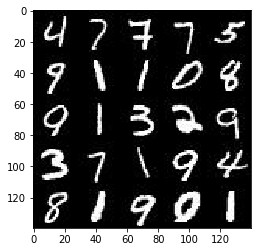

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

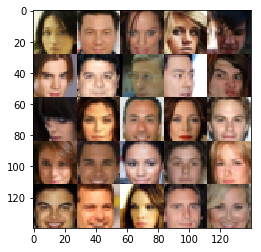

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 
                               name = 'real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), 
                             name = 'z_input')
    learning_rate = tf.placeholder(tf.float32, None, name = 'learning_rate')
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [32]:
def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.75):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        d1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        relu1 = tf.maximum(alpha * d1, d1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        d2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        bn2 = tf.layers.batch_normalization(d2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        d3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        bn3 = tf.layers.batch_normalization(d3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    
    
    
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [33]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, keep_prob=0.8):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not (is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
    
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [34]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, keep_prob=0.8):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha, is_train=True, keep_prob=keep_prob)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha, reuse=False, keep_prob=keep_prob)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha, keep_prob=keep_prob)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    
    
    
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [35]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    
    
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [36]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [39]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    alpha = 0.15
    keep_prob=0.8
    n_samples, width, height, channels = data_shape
    input_real, input_z, learning_rate_1 = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels, alpha=alpha, keep_prob=keep_prob)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_1, beta1)
    
    current_step = 0
    print_loss_every = 10
    show_image_every = 200
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                current_step +=1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_z = batch_z.reshape(batch_size, z_dim)
                
                _= sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_1:learning_rate})
                for i in range(3):    
                    _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate_1:learning_rate})
               
                if current_step % print_loss_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if current_step % show_image_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 3.2160... Generator Loss: 0.2680
Epoch 0/2... Discriminator Loss: 2.1722... Generator Loss: 0.5680
Epoch 0/2... Discriminator Loss: 2.3540... Generator Loss: 0.6564
Epoch 0/2... Discriminator Loss: 2.3159... Generator Loss: 0.5275
Epoch 0/2... Discriminator Loss: 1.8103... Generator Loss: 0.9152
Epoch 0/2... Discriminator Loss: 2.0516... Generator Loss: 0.4345
Epoch 0/2... Discriminator Loss: 1.6155... Generator Loss: 1.1185
Epoch 0/2... Discriminator Loss: 1.8254... Generator Loss: 0.6744
Epoch 0/2... Discriminator Loss: 1.6433... Generator Loss: 0.7377
Epoch 0/2... Discriminator Loss: 1.1743... Generator Loss: 1.3116
Epoch 0/2... Discriminator Loss: 1.2043... Generator Loss: 0.8643
Epoch 0/2... Discriminator Loss: 1.7820... Generator Loss: 0.7694
Epoch 0/2... Discriminator Loss: 1.9279... Generator Loss: 0.7590
Epoch 0/2... Discriminator Loss: 1.5278... Generator Loss: 0.8092
Epoch 0/2... Discriminator Loss: 1.8925... Generator Loss: 0.6989
Epoch 0/2.

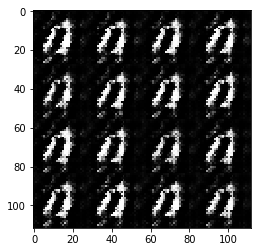

Epoch 0/2... Discriminator Loss: 1.3273... Generator Loss: 0.8431
Epoch 0/2... Discriminator Loss: 1.1736... Generator Loss: 1.3414
Epoch 0/2... Discriminator Loss: 1.2722... Generator Loss: 1.1017
Epoch 0/2... Discriminator Loss: 1.3447... Generator Loss: 1.0971
Epoch 0/2... Discriminator Loss: 1.2371... Generator Loss: 0.9494
Epoch 0/2... Discriminator Loss: 0.6828... Generator Loss: 1.9800
Epoch 0/2... Discriminator Loss: 1.1273... Generator Loss: 1.0472
Epoch 0/2... Discriminator Loss: 1.4189... Generator Loss: 0.6716
Epoch 0/2... Discriminator Loss: 1.4277... Generator Loss: 1.0721
Epoch 0/2... Discriminator Loss: 1.4655... Generator Loss: 1.0412
Epoch 0/2... Discriminator Loss: 1.9345... Generator Loss: 0.7927
Epoch 0/2... Discriminator Loss: 0.9716... Generator Loss: 1.5381
Epoch 0/2... Discriminator Loss: 1.8062... Generator Loss: 0.8607
Epoch 0/2... Discriminator Loss: 1.0547... Generator Loss: 1.2756
Epoch 0/2... Discriminator Loss: 1.4210... Generator Loss: 0.6817
Epoch 0/2.

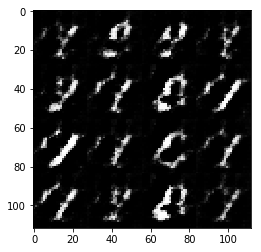

Epoch 0/2... Discriminator Loss: 1.6363... Generator Loss: 0.8988
Epoch 0/2... Discriminator Loss: 1.2227... Generator Loss: 1.0225
Epoch 0/2... Discriminator Loss: 1.7213... Generator Loss: 0.9925
Epoch 0/2... Discriminator Loss: 1.3521... Generator Loss: 0.8006
Epoch 0/2... Discriminator Loss: 1.4511... Generator Loss: 0.8718
Epoch 0/2... Discriminator Loss: 1.3140... Generator Loss: 1.0434
Epoch 0/2... Discriminator Loss: 1.6253... Generator Loss: 0.6612
Epoch 0/2... Discriminator Loss: 1.4529... Generator Loss: 0.8532
Epoch 0/2... Discriminator Loss: 1.7179... Generator Loss: 0.8024
Epoch 0/2... Discriminator Loss: 1.5380... Generator Loss: 0.8446
Epoch 0/2... Discriminator Loss: 1.4386... Generator Loss: 0.7930
Epoch 0/2... Discriminator Loss: 1.3197... Generator Loss: 0.7710
Epoch 0/2... Discriminator Loss: 1.4737... Generator Loss: 0.6912
Epoch 0/2... Discriminator Loss: 1.3152... Generator Loss: 0.6985
Epoch 0/2... Discriminator Loss: 1.5493... Generator Loss: 0.8340
Epoch 0/2.

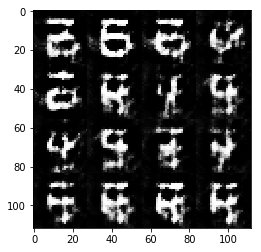

Epoch 0/2... Discriminator Loss: 1.4260... Generator Loss: 0.7328
Epoch 0/2... Discriminator Loss: 1.3278... Generator Loss: 0.8013
Epoch 0/2... Discriminator Loss: 1.4874... Generator Loss: 0.8492
Epoch 0/2... Discriminator Loss: 1.2169... Generator Loss: 1.0493
Epoch 0/2... Discriminator Loss: 1.4762... Generator Loss: 0.8846
Epoch 0/2... Discriminator Loss: 1.3260... Generator Loss: 0.7858
Epoch 0/2... Discriminator Loss: 1.4972... Generator Loss: 0.8471
Epoch 0/2... Discriminator Loss: 1.3723... Generator Loss: 0.8331
Epoch 0/2... Discriminator Loss: 1.5566... Generator Loss: 0.7522
Epoch 0/2... Discriminator Loss: 1.3131... Generator Loss: 0.8708
Epoch 0/2... Discriminator Loss: 1.6388... Generator Loss: 0.8168
Epoch 0/2... Discriminator Loss: 1.4238... Generator Loss: 0.6542
Epoch 0/2... Discriminator Loss: 1.4208... Generator Loss: 0.9289
Epoch 0/2... Discriminator Loss: 1.4846... Generator Loss: 0.7590
Epoch 0/2... Discriminator Loss: 1.5743... Generator Loss: 0.7056
Epoch 0/2.

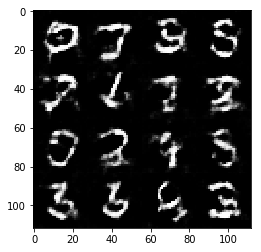

Epoch 0/2... Discriminator Loss: 1.5192... Generator Loss: 0.6567
Epoch 0/2... Discriminator Loss: 1.4422... Generator Loss: 0.7142
Epoch 0/2... Discriminator Loss: 1.3060... Generator Loss: 0.9213
Epoch 0/2... Discriminator Loss: 1.4884... Generator Loss: 0.6784
Epoch 0/2... Discriminator Loss: 1.4473... Generator Loss: 0.7672
Epoch 0/2... Discriminator Loss: 1.4481... Generator Loss: 0.6815
Epoch 0/2... Discriminator Loss: 1.5477... Generator Loss: 0.6971
Epoch 0/2... Discriminator Loss: 1.5583... Generator Loss: 0.6653
Epoch 0/2... Discriminator Loss: 1.4267... Generator Loss: 0.6711
Epoch 0/2... Discriminator Loss: 1.4221... Generator Loss: 0.7620
Epoch 0/2... Discriminator Loss: 1.4727... Generator Loss: 0.7937
Epoch 0/2... Discriminator Loss: 1.4958... Generator Loss: 0.7816
Epoch 0/2... Discriminator Loss: 1.3811... Generator Loss: 0.9895
Epoch 0/2... Discriminator Loss: 1.3230... Generator Loss: 0.6939
Epoch 0/2... Discriminator Loss: 1.5327... Generator Loss: 0.7569
Epoch 0/2.

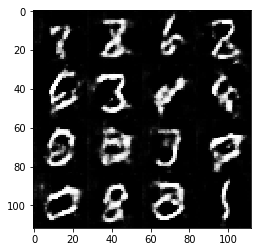

Epoch 0/2... Discriminator Loss: 1.4378... Generator Loss: 0.8306
Epoch 0/2... Discriminator Loss: 1.4503... Generator Loss: 0.6890
Epoch 0/2... Discriminator Loss: 1.3980... Generator Loss: 0.7040
Epoch 0/2... Discriminator Loss: 1.4161... Generator Loss: 0.9205
Epoch 0/2... Discriminator Loss: 1.3776... Generator Loss: 1.1050
Epoch 0/2... Discriminator Loss: 1.3433... Generator Loss: 0.8928
Epoch 0/2... Discriminator Loss: 1.4496... Generator Loss: 0.7113
Epoch 0/2... Discriminator Loss: 1.4308... Generator Loss: 0.8282
Epoch 0/2... Discriminator Loss: 1.4796... Generator Loss: 0.7951
Epoch 0/2... Discriminator Loss: 1.5068... Generator Loss: 0.7072
Epoch 0/2... Discriminator Loss: 1.5348... Generator Loss: 0.8033
Epoch 0/2... Discriminator Loss: 1.5230... Generator Loss: 0.7582
Epoch 0/2... Discriminator Loss: 1.4923... Generator Loss: 0.7918
Epoch 0/2... Discriminator Loss: 1.4271... Generator Loss: 0.7027
Epoch 0/2... Discriminator Loss: 1.5861... Generator Loss: 0.7533
Epoch 0/2.

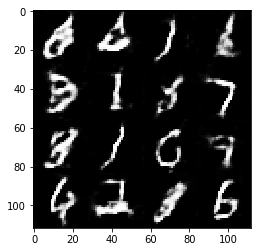

Epoch 0/2... Discriminator Loss: 1.4221... Generator Loss: 0.8308
Epoch 0/2... Discriminator Loss: 1.4120... Generator Loss: 0.7398
Epoch 0/2... Discriminator Loss: 1.4425... Generator Loss: 0.7980
Epoch 0/2... Discriminator Loss: 1.3527... Generator Loss: 0.7795
Epoch 0/2... Discriminator Loss: 1.3318... Generator Loss: 0.9235
Epoch 0/2... Discriminator Loss: 1.4133... Generator Loss: 0.6860
Epoch 0/2... Discriminator Loss: 1.5164... Generator Loss: 0.7350
Epoch 0/2... Discriminator Loss: 1.3670... Generator Loss: 0.7819
Epoch 0/2... Discriminator Loss: 1.3347... Generator Loss: 0.9646
Epoch 0/2... Discriminator Loss: 1.5301... Generator Loss: 0.7435
Epoch 0/2... Discriminator Loss: 1.3864... Generator Loss: 0.8006
Epoch 0/2... Discriminator Loss: 1.4246... Generator Loss: 0.8394
Epoch 0/2... Discriminator Loss: 1.3740... Generator Loss: 0.9825
Epoch 0/2... Discriminator Loss: 1.4121... Generator Loss: 0.6920
Epoch 0/2... Discriminator Loss: 1.5197... Generator Loss: 0.7149
Epoch 0/2.

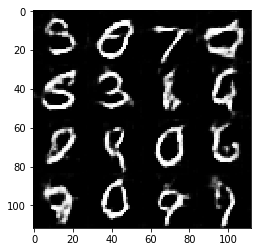

Epoch 0/2... Discriminator Loss: 1.3212... Generator Loss: 0.7560
Epoch 0/2... Discriminator Loss: 1.4414... Generator Loss: 0.9671
Epoch 0/2... Discriminator Loss: 1.5244... Generator Loss: 0.6849
Epoch 0/2... Discriminator Loss: 1.3900... Generator Loss: 1.0121
Epoch 0/2... Discriminator Loss: 1.5543... Generator Loss: 0.6518
Epoch 0/2... Discriminator Loss: 1.3619... Generator Loss: 0.9554
Epoch 0/2... Discriminator Loss: 1.3917... Generator Loss: 0.8895
Epoch 0/2... Discriminator Loss: 1.4212... Generator Loss: 0.7225
Epoch 0/2... Discriminator Loss: 1.4692... Generator Loss: 0.8227
Epoch 0/2... Discriminator Loss: 1.3377... Generator Loss: 0.7095
Epoch 0/2... Discriminator Loss: 1.3844... Generator Loss: 0.8453
Epoch 0/2... Discriminator Loss: 1.4646... Generator Loss: 0.8310
Epoch 0/2... Discriminator Loss: 1.4429... Generator Loss: 0.8359
Epoch 0/2... Discriminator Loss: 1.4520... Generator Loss: 0.8582
Epoch 0/2... Discriminator Loss: 1.4231... Generator Loss: 0.9036
Epoch 0/2.

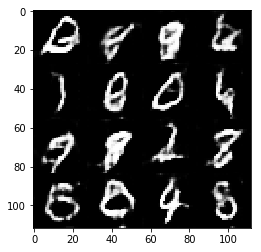

Epoch 0/2... Discriminator Loss: 1.4743... Generator Loss: 0.8217
Epoch 0/2... Discriminator Loss: 1.5056... Generator Loss: 0.7598
Epoch 0/2... Discriminator Loss: 1.4113... Generator Loss: 0.9204
Epoch 0/2... Discriminator Loss: 1.3821... Generator Loss: 0.7947
Epoch 0/2... Discriminator Loss: 1.3752... Generator Loss: 0.9145
Epoch 0/2... Discriminator Loss: 1.3536... Generator Loss: 0.6539
Epoch 0/2... Discriminator Loss: 1.5276... Generator Loss: 0.6965
Epoch 0/2... Discriminator Loss: 1.4012... Generator Loss: 0.5923
Epoch 0/2... Discriminator Loss: 1.2487... Generator Loss: 1.0155
Epoch 0/2... Discriminator Loss: 1.3859... Generator Loss: 0.8123
Epoch 0/2... Discriminator Loss: 1.3920... Generator Loss: 0.9345
Epoch 0/2... Discriminator Loss: 1.3448... Generator Loss: 0.7844
Epoch 0/2... Discriminator Loss: 1.3468... Generator Loss: 0.7960
Epoch 0/2... Discriminator Loss: 1.4474... Generator Loss: 0.9044
Epoch 0/2... Discriminator Loss: 1.4441... Generator Loss: 0.8868
Epoch 0/2.

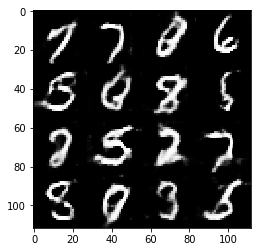

Epoch 0/2... Discriminator Loss: 1.3784... Generator Loss: 0.8225
Epoch 0/2... Discriminator Loss: 1.3478... Generator Loss: 0.7620
Epoch 0/2... Discriminator Loss: 1.4109... Generator Loss: 0.9531
Epoch 0/2... Discriminator Loss: 1.4278... Generator Loss: 0.6693
Epoch 0/2... Discriminator Loss: 1.3463... Generator Loss: 0.8966
Epoch 0/2... Discriminator Loss: 1.3498... Generator Loss: 0.7498
Epoch 0/2... Discriminator Loss: 1.4387... Generator Loss: 0.7329
Epoch 1/2... Discriminator Loss: 1.3438... Generator Loss: 0.8760
Epoch 1/2... Discriminator Loss: 1.4408... Generator Loss: 0.6062
Epoch 1/2... Discriminator Loss: 1.4122... Generator Loss: 0.7246
Epoch 1/2... Discriminator Loss: 1.4422... Generator Loss: 0.9380
Epoch 1/2... Discriminator Loss: 1.4001... Generator Loss: 0.7610
Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 0.8700
Epoch 1/2... Discriminator Loss: 1.4481... Generator Loss: 0.6618
Epoch 1/2... Discriminator Loss: 1.3977... Generator Loss: 0.7477
Epoch 1/2.

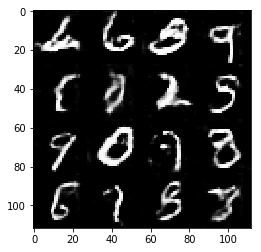

Epoch 1/2... Discriminator Loss: 1.4680... Generator Loss: 0.6458
Epoch 1/2... Discriminator Loss: 1.3213... Generator Loss: 0.9613
Epoch 1/2... Discriminator Loss: 1.4826... Generator Loss: 0.5846
Epoch 1/2... Discriminator Loss: 1.3979... Generator Loss: 0.8895
Epoch 1/2... Discriminator Loss: 1.2339... Generator Loss: 0.8467
Epoch 1/2... Discriminator Loss: 1.4490... Generator Loss: 0.6406
Epoch 1/2... Discriminator Loss: 1.4551... Generator Loss: 0.7199
Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 0.7235
Epoch 1/2... Discriminator Loss: 1.3850... Generator Loss: 0.6464
Epoch 1/2... Discriminator Loss: 1.1975... Generator Loss: 0.7500
Epoch 1/2... Discriminator Loss: 1.4775... Generator Loss: 0.7121
Epoch 1/2... Discriminator Loss: 1.4032... Generator Loss: 0.8439
Epoch 1/2... Discriminator Loss: 1.3253... Generator Loss: 0.8602
Epoch 1/2... Discriminator Loss: 1.4147... Generator Loss: 0.7611
Epoch 1/2... Discriminator Loss: 1.3681... Generator Loss: 0.9657
Epoch 1/2.

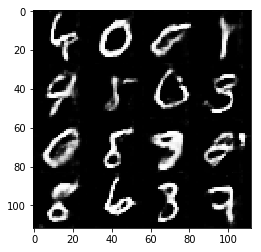

Epoch 1/2... Discriminator Loss: 1.4379... Generator Loss: 0.7205
Epoch 1/2... Discriminator Loss: 1.4005... Generator Loss: 0.7531
Epoch 1/2... Discriminator Loss: 1.4174... Generator Loss: 0.8386
Epoch 1/2... Discriminator Loss: 1.4073... Generator Loss: 0.9580
Epoch 1/2... Discriminator Loss: 1.4361... Generator Loss: 0.7892
Epoch 1/2... Discriminator Loss: 1.4253... Generator Loss: 0.9676
Epoch 1/2... Discriminator Loss: 1.3079... Generator Loss: 0.9562
Epoch 1/2... Discriminator Loss: 1.3810... Generator Loss: 0.8471
Epoch 1/2... Discriminator Loss: 1.4441... Generator Loss: 0.7727
Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 0.6317
Epoch 1/2... Discriminator Loss: 1.3142... Generator Loss: 1.0488
Epoch 1/2... Discriminator Loss: 1.4041... Generator Loss: 0.6488
Epoch 1/2... Discriminator Loss: 1.4340... Generator Loss: 0.7675
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7981
Epoch 1/2... Discriminator Loss: 1.4914... Generator Loss: 0.6770
Epoch 1/2.

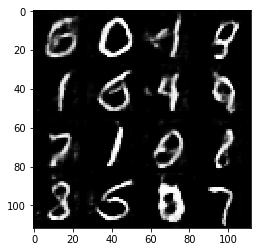

Epoch 1/2... Discriminator Loss: 1.3239... Generator Loss: 0.6391
Epoch 1/2... Discriminator Loss: 1.3472... Generator Loss: 0.5853
Epoch 1/2... Discriminator Loss: 1.3825... Generator Loss: 0.6833
Epoch 1/2... Discriminator Loss: 1.4194... Generator Loss: 0.7222
Epoch 1/2... Discriminator Loss: 1.4236... Generator Loss: 0.8103
Epoch 1/2... Discriminator Loss: 1.3092... Generator Loss: 0.8317
Epoch 1/2... Discriminator Loss: 1.4228... Generator Loss: 0.6369
Epoch 1/2... Discriminator Loss: 1.3115... Generator Loss: 1.0734
Epoch 1/2... Discriminator Loss: 1.4462... Generator Loss: 0.7854
Epoch 1/2... Discriminator Loss: 1.3759... Generator Loss: 0.7773
Epoch 1/2... Discriminator Loss: 1.4687... Generator Loss: 0.7026
Epoch 1/2... Discriminator Loss: 1.4408... Generator Loss: 0.5310
Epoch 1/2... Discriminator Loss: 1.5014... Generator Loss: 0.9243
Epoch 1/2... Discriminator Loss: 1.4179... Generator Loss: 0.8894
Epoch 1/2... Discriminator Loss: 1.4286... Generator Loss: 0.7776
Epoch 1/2.

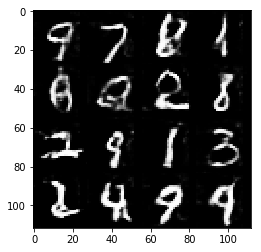

Epoch 1/2... Discriminator Loss: 1.4492... Generator Loss: 0.8441
Epoch 1/2... Discriminator Loss: 1.3884... Generator Loss: 0.5579
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.7132
Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 0.8303
Epoch 1/2... Discriminator Loss: 1.4306... Generator Loss: 0.5836
Epoch 1/2... Discriminator Loss: 1.3285... Generator Loss: 0.9914
Epoch 1/2... Discriminator Loss: 1.3858... Generator Loss: 0.7157
Epoch 1/2... Discriminator Loss: 1.4976... Generator Loss: 0.6012
Epoch 1/2... Discriminator Loss: 1.3663... Generator Loss: 0.6618
Epoch 1/2... Discriminator Loss: 1.3210... Generator Loss: 0.8982
Epoch 1/2... Discriminator Loss: 1.2700... Generator Loss: 0.7203
Epoch 1/2... Discriminator Loss: 1.3319... Generator Loss: 0.9184
Epoch 1/2... Discriminator Loss: 1.3748... Generator Loss: 0.6639
Epoch 1/2... Discriminator Loss: 1.3453... Generator Loss: 0.7456
Epoch 1/2... Discriminator Loss: 1.4511... Generator Loss: 0.6679
Epoch 1/2.

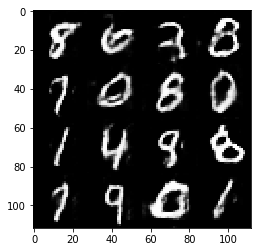

Epoch 1/2... Discriminator Loss: 1.3745... Generator Loss: 0.7390
Epoch 1/2... Discriminator Loss: 1.3554... Generator Loss: 0.6854
Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 0.9709
Epoch 1/2... Discriminator Loss: 1.4432... Generator Loss: 1.0668
Epoch 1/2... Discriminator Loss: 1.4852... Generator Loss: 0.7168
Epoch 1/2... Discriminator Loss: 1.2650... Generator Loss: 0.8516
Epoch 1/2... Discriminator Loss: 1.2934... Generator Loss: 0.9854
Epoch 1/2... Discriminator Loss: 1.3134... Generator Loss: 0.8959
Epoch 1/2... Discriminator Loss: 1.3463... Generator Loss: 0.7521
Epoch 1/2... Discriminator Loss: 1.3051... Generator Loss: 0.6038
Epoch 1/2... Discriminator Loss: 1.4451... Generator Loss: 0.5913
Epoch 1/2... Discriminator Loss: 1.3332... Generator Loss: 0.8901
Epoch 1/2... Discriminator Loss: 1.3553... Generator Loss: 0.6916
Epoch 1/2... Discriminator Loss: 1.3667... Generator Loss: 0.8075
Epoch 1/2... Discriminator Loss: 1.4655... Generator Loss: 0.7682
Epoch 1/2.

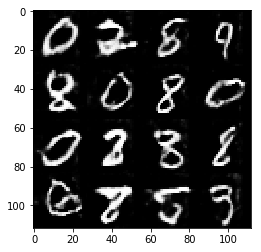

Epoch 1/2... Discriminator Loss: 1.4105... Generator Loss: 0.9240
Epoch 1/2... Discriminator Loss: 1.3533... Generator Loss: 0.7615
Epoch 1/2... Discriminator Loss: 1.3164... Generator Loss: 1.0031
Epoch 1/2... Discriminator Loss: 1.2382... Generator Loss: 0.8019
Epoch 1/2... Discriminator Loss: 1.2290... Generator Loss: 1.1732
Epoch 1/2... Discriminator Loss: 1.5665... Generator Loss: 0.4823
Epoch 1/2... Discriminator Loss: 1.4013... Generator Loss: 1.2328
Epoch 1/2... Discriminator Loss: 1.3117... Generator Loss: 0.7257
Epoch 1/2... Discriminator Loss: 1.2478... Generator Loss: 0.8078
Epoch 1/2... Discriminator Loss: 1.5708... Generator Loss: 1.3577
Epoch 1/2... Discriminator Loss: 1.3360... Generator Loss: 0.8709
Epoch 1/2... Discriminator Loss: 1.2355... Generator Loss: 1.1544
Epoch 1/2... Discriminator Loss: 1.2353... Generator Loss: 0.8062
Epoch 1/2... Discriminator Loss: 1.2917... Generator Loss: 0.8486
Epoch 1/2... Discriminator Loss: 1.2431... Generator Loss: 0.7534
Epoch 1/2.

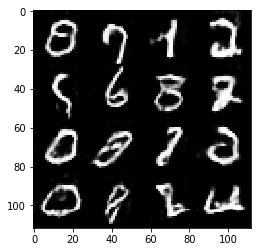

Epoch 1/2... Discriminator Loss: 1.2819... Generator Loss: 0.9492
Epoch 1/2... Discriminator Loss: 1.2764... Generator Loss: 1.0448
Epoch 1/2... Discriminator Loss: 1.2770... Generator Loss: 0.9348
Epoch 1/2... Discriminator Loss: 1.3184... Generator Loss: 0.7813
Epoch 1/2... Discriminator Loss: 1.3652... Generator Loss: 0.6176
Epoch 1/2... Discriminator Loss: 1.5220... Generator Loss: 1.1938
Epoch 1/2... Discriminator Loss: 1.3612... Generator Loss: 0.5241
Epoch 1/2... Discriminator Loss: 1.2757... Generator Loss: 0.7750
Epoch 1/2... Discriminator Loss: 1.4138... Generator Loss: 1.2313
Epoch 1/2... Discriminator Loss: 1.4313... Generator Loss: 1.1936
Epoch 1/2... Discriminator Loss: 1.3374... Generator Loss: 1.3779
Epoch 1/2... Discriminator Loss: 1.2981... Generator Loss: 0.7514
Epoch 1/2... Discriminator Loss: 1.2449... Generator Loss: 0.9745
Epoch 1/2... Discriminator Loss: 1.2433... Generator Loss: 0.9119
Epoch 1/2... Discriminator Loss: 1.2045... Generator Loss: 1.0286
Epoch 1/2.

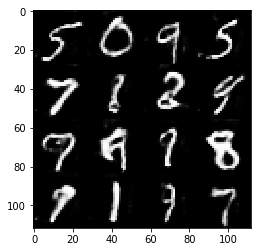

Epoch 1/2... Discriminator Loss: 1.3031... Generator Loss: 0.9853
Epoch 1/2... Discriminator Loss: 1.2634... Generator Loss: 1.0435
Epoch 1/2... Discriminator Loss: 1.4797... Generator Loss: 0.5426
Epoch 1/2... Discriminator Loss: 1.5208... Generator Loss: 0.6499
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.9887
Epoch 1/2... Discriminator Loss: 1.3157... Generator Loss: 1.2856
Epoch 1/2... Discriminator Loss: 1.2546... Generator Loss: 0.8438
Epoch 1/2... Discriminator Loss: 1.3374... Generator Loss: 0.6271
Epoch 1/2... Discriminator Loss: 1.1445... Generator Loss: 1.4039
Epoch 1/2... Discriminator Loss: 1.4449... Generator Loss: 0.6964
Epoch 1/2... Discriminator Loss: 1.2058... Generator Loss: 0.8089
Epoch 1/2... Discriminator Loss: 1.4076... Generator Loss: 0.6064
Epoch 1/2... Discriminator Loss: 1.2796... Generator Loss: 1.2495
Epoch 1/2... Discriminator Loss: 1.3448... Generator Loss: 0.6376
Epoch 1/2... Discriminator Loss: 1.2166... Generator Loss: 0.6397
Epoch 1/2.

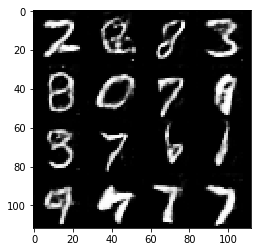

Epoch 1/2... Discriminator Loss: 1.2265... Generator Loss: 0.9821
Epoch 1/2... Discriminator Loss: 1.1558... Generator Loss: 0.6876
Epoch 1/2... Discriminator Loss: 1.2607... Generator Loss: 1.2496
Epoch 1/2... Discriminator Loss: 1.3557... Generator Loss: 0.6431
Epoch 1/2... Discriminator Loss: 1.3056... Generator Loss: 1.2159
Epoch 1/2... Discriminator Loss: 1.1995... Generator Loss: 0.6725
Epoch 1/2... Discriminator Loss: 1.5590... Generator Loss: 0.7333
Epoch 1/2... Discriminator Loss: 1.5299... Generator Loss: 0.5274
Epoch 1/2... Discriminator Loss: 1.1017... Generator Loss: 1.0846
Epoch 1/2... Discriminator Loss: 1.1783... Generator Loss: 0.9240
Epoch 1/2... Discriminator Loss: 1.2591... Generator Loss: 1.0702
Epoch 1/2... Discriminator Loss: 1.1423... Generator Loss: 0.9979
Epoch 1/2... Discriminator Loss: 1.2372... Generator Loss: 1.0043
Epoch 1/2... Discriminator Loss: 1.2530... Generator Loss: 0.8582
Epoch 1/2... Discriminator Loss: 1.2314... Generator Loss: 0.8578


In [41]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/2... Discriminator Loss: 3.1142... Generator Loss: 0.3231
Epoch 0/2... Discriminator Loss: 2.7713... Generator Loss: 0.5907
Epoch 0/2... Discriminator Loss: 2.9263... Generator Loss: 0.1971
Epoch 0/2... Discriminator Loss: 2.3859... Generator Loss: 0.7135
Epoch 0/2... Discriminator Loss: 2.4359... Generator Loss: 0.7731
Epoch 0/2... Discriminator Loss: 1.7627... Generator Loss: 0.6040
Epoch 0/2... Discriminator Loss: 1.1311... Generator Loss: 1.3175
Epoch 0/2... Discriminator Loss: 1.3200... Generator Loss: 1.2294
Epoch 0/2... Discriminator Loss: 1.1284... Generator Loss: 1.6081
Epoch 0/2... Discriminator Loss: 1.1214... Generator Loss: 0.8888
Epoch 0/2... Discriminator Loss: 1.2780... Generator Loss: 1.1444
Epoch 0/2... Discriminator Loss: 1.0943... Generator Loss: 1.2929
Epoch 0/2... Discriminator Loss: 2.1044... Generator Loss: 0.5728
Epoch 0/2... Discriminator Loss: 1.6860... Generator Loss: 0.7139
Epoch 0/2... Discriminator Loss: 1.8657... Generator Loss: 0.5581
Epoch 0/2.

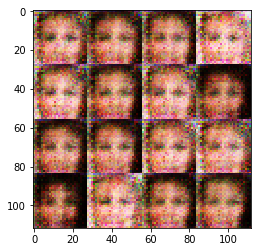

Epoch 0/2... Discriminator Loss: 1.4307... Generator Loss: 0.8919
Epoch 0/2... Discriminator Loss: 1.9433... Generator Loss: 0.5579
Epoch 0/2... Discriminator Loss: 1.4304... Generator Loss: 0.9229
Epoch 0/2... Discriminator Loss: 1.2994... Generator Loss: 0.9325
Epoch 0/2... Discriminator Loss: 1.1711... Generator Loss: 1.0001
Epoch 0/2... Discriminator Loss: 1.3462... Generator Loss: 0.8381
Epoch 0/2... Discriminator Loss: 1.8033... Generator Loss: 0.6750
Epoch 0/2... Discriminator Loss: 1.4749... Generator Loss: 0.7591
Epoch 0/2... Discriminator Loss: 1.8104... Generator Loss: 0.5792
Epoch 0/2... Discriminator Loss: 1.5085... Generator Loss: 0.7661
Epoch 0/2... Discriminator Loss: 1.6316... Generator Loss: 0.8057
Epoch 0/2... Discriminator Loss: 1.5458... Generator Loss: 0.7241
Epoch 0/2... Discriminator Loss: 1.3988... Generator Loss: 0.7150
Epoch 0/2... Discriminator Loss: 1.4446... Generator Loss: 0.8966
Epoch 0/2... Discriminator Loss: 1.6323... Generator Loss: 0.7778
Epoch 0/2.

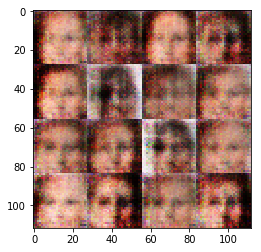

Epoch 0/2... Discriminator Loss: 1.4161... Generator Loss: 0.8723
Epoch 0/2... Discriminator Loss: 1.7030... Generator Loss: 0.6416
Epoch 0/2... Discriminator Loss: 1.5753... Generator Loss: 0.8663
Epoch 0/2... Discriminator Loss: 1.4502... Generator Loss: 0.8779
Epoch 0/2... Discriminator Loss: 1.5871... Generator Loss: 0.6910
Epoch 0/2... Discriminator Loss: 1.5485... Generator Loss: 0.7298
Epoch 0/2... Discriminator Loss: 1.4212... Generator Loss: 0.9087
Epoch 0/2... Discriminator Loss: 1.4470... Generator Loss: 0.8452
Epoch 0/2... Discriminator Loss: 1.5316... Generator Loss: 0.7110
Epoch 0/2... Discriminator Loss: 1.5750... Generator Loss: 0.7887
Epoch 0/2... Discriminator Loss: 1.5170... Generator Loss: 0.7123
Epoch 0/2... Discriminator Loss: 1.5945... Generator Loss: 0.7258
Epoch 0/2... Discriminator Loss: 1.5425... Generator Loss: 0.7314
Epoch 0/2... Discriminator Loss: 1.3647... Generator Loss: 0.7345
Epoch 0/2... Discriminator Loss: 1.5877... Generator Loss: 0.6988
Epoch 0/2.

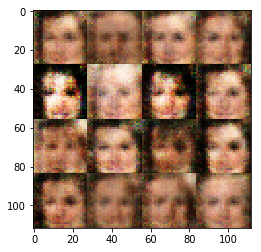

Epoch 0/2... Discriminator Loss: 1.4996... Generator Loss: 0.8733
Epoch 0/2... Discriminator Loss: 1.4853... Generator Loss: 0.7944
Epoch 0/2... Discriminator Loss: 1.6368... Generator Loss: 0.7562
Epoch 0/2... Discriminator Loss: 1.4884... Generator Loss: 0.7121
Epoch 0/2... Discriminator Loss: 1.4299... Generator Loss: 0.7825
Epoch 0/2... Discriminator Loss: 1.5091... Generator Loss: 0.6833
Epoch 0/2... Discriminator Loss: 1.4510... Generator Loss: 0.7219
Epoch 0/2... Discriminator Loss: 1.4783... Generator Loss: 0.7655
Epoch 0/2... Discriminator Loss: 1.4380... Generator Loss: 0.7399
Epoch 0/2... Discriminator Loss: 1.5965... Generator Loss: 0.7082
Epoch 0/2... Discriminator Loss: 1.4395... Generator Loss: 0.7495
Epoch 0/2... Discriminator Loss: 1.5051... Generator Loss: 0.9371
Epoch 0/2... Discriminator Loss: 1.5086... Generator Loss: 0.7066
Epoch 0/2... Discriminator Loss: 1.4827... Generator Loss: 0.7274
Epoch 0/2... Discriminator Loss: 1.5204... Generator Loss: 0.7410
Epoch 0/2.

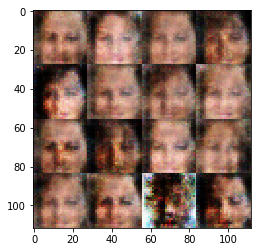

Epoch 0/2... Discriminator Loss: 1.5236... Generator Loss: 0.7495
Epoch 0/2... Discriminator Loss: 1.3722... Generator Loss: 0.7629
Epoch 0/2... Discriminator Loss: 1.4629... Generator Loss: 0.9039
Epoch 0/2... Discriminator Loss: 1.3831... Generator Loss: 0.7674
Epoch 0/2... Discriminator Loss: 1.5704... Generator Loss: 0.6735
Epoch 0/2... Discriminator Loss: 1.4699... Generator Loss: 0.7109
Epoch 0/2... Discriminator Loss: 1.4246... Generator Loss: 0.7701
Epoch 0/2... Discriminator Loss: 1.4869... Generator Loss: 0.6988
Epoch 0/2... Discriminator Loss: 1.5211... Generator Loss: 0.8020
Epoch 0/2... Discriminator Loss: 1.4555... Generator Loss: 0.7695
Epoch 0/2... Discriminator Loss: 1.5220... Generator Loss: 0.7608
Epoch 0/2... Discriminator Loss: 1.4708... Generator Loss: 0.7223
Epoch 0/2... Discriminator Loss: 1.4476... Generator Loss: 0.6969
Epoch 0/2... Discriminator Loss: 1.4415... Generator Loss: 0.8207
Epoch 0/2... Discriminator Loss: 1.4913... Generator Loss: 0.7281
Epoch 0/2.

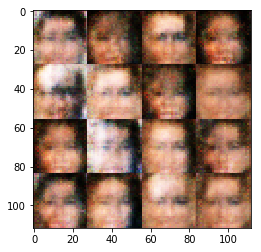

Epoch 0/2... Discriminator Loss: 1.4262... Generator Loss: 0.7700
Epoch 0/2... Discriminator Loss: 1.4228... Generator Loss: 0.7686
Epoch 0/2... Discriminator Loss: 1.5330... Generator Loss: 0.8325
Epoch 0/2... Discriminator Loss: 1.4401... Generator Loss: 0.7371
Epoch 0/2... Discriminator Loss: 1.3855... Generator Loss: 0.7626
Epoch 0/2... Discriminator Loss: 1.5336... Generator Loss: 0.7206
Epoch 0/2... Discriminator Loss: 1.4049... Generator Loss: 0.7985
Epoch 0/2... Discriminator Loss: 1.4050... Generator Loss: 0.8077
Epoch 0/2... Discriminator Loss: 1.4321... Generator Loss: 0.7551
Epoch 0/2... Discriminator Loss: 1.4396... Generator Loss: 0.7288
Epoch 0/2... Discriminator Loss: 1.4632... Generator Loss: 0.8523
Epoch 0/2... Discriminator Loss: 1.4496... Generator Loss: 0.7874
Epoch 0/2... Discriminator Loss: 1.4835... Generator Loss: 0.7785
Epoch 0/2... Discriminator Loss: 1.4005... Generator Loss: 0.7368
Epoch 0/2... Discriminator Loss: 1.4211... Generator Loss: 0.8022
Epoch 0/2.

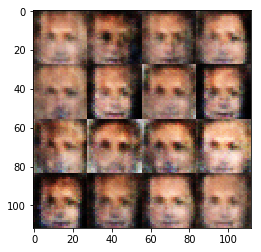

Epoch 0/2... Discriminator Loss: 1.4886... Generator Loss: 0.7933
Epoch 0/2... Discriminator Loss: 1.4302... Generator Loss: 0.7989
Epoch 0/2... Discriminator Loss: 1.4408... Generator Loss: 0.7528
Epoch 0/2... Discriminator Loss: 1.4263... Generator Loss: 0.7876
Epoch 0/2... Discriminator Loss: 1.4776... Generator Loss: 0.8031
Epoch 0/2... Discriminator Loss: 1.4427... Generator Loss: 0.7363
Epoch 0/2... Discriminator Loss: 1.3774... Generator Loss: 0.7136
Epoch 0/2... Discriminator Loss: 1.4449... Generator Loss: 0.7285
Epoch 0/2... Discriminator Loss: 1.3723... Generator Loss: 0.8771
Epoch 0/2... Discriminator Loss: 1.4161... Generator Loss: 0.7570
Epoch 0/2... Discriminator Loss: 1.4281... Generator Loss: 0.6984
Epoch 0/2... Discriminator Loss: 1.4505... Generator Loss: 0.7598
Epoch 0/2... Discriminator Loss: 1.4223... Generator Loss: 0.8884
Epoch 0/2... Discriminator Loss: 1.4503... Generator Loss: 0.7654
Epoch 0/2... Discriminator Loss: 1.4426... Generator Loss: 0.8430
Epoch 0/2.

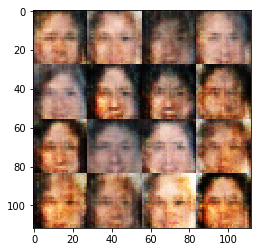

Epoch 0/2... Discriminator Loss: 1.4353... Generator Loss: 0.7977
Epoch 0/2... Discriminator Loss: 1.3905... Generator Loss: 0.7765
Epoch 0/2... Discriminator Loss: 1.4224... Generator Loss: 0.8595
Epoch 0/2... Discriminator Loss: 1.4431... Generator Loss: 0.7445
Epoch 0/2... Discriminator Loss: 1.4766... Generator Loss: 0.7992
Epoch 0/2... Discriminator Loss: 1.4466... Generator Loss: 0.7583
Epoch 0/2... Discriminator Loss: 1.4639... Generator Loss: 0.7633
Epoch 0/2... Discriminator Loss: 1.4797... Generator Loss: 0.8153
Epoch 0/2... Discriminator Loss: 1.4230... Generator Loss: 0.7743
Epoch 0/2... Discriminator Loss: 1.4347... Generator Loss: 0.7835
Epoch 0/2... Discriminator Loss: 1.3907... Generator Loss: 0.7391
Epoch 0/2... Discriminator Loss: 1.3790... Generator Loss: 0.7810
Epoch 0/2... Discriminator Loss: 1.4108... Generator Loss: 0.7558
Epoch 0/2... Discriminator Loss: 1.4531... Generator Loss: 0.7173
Epoch 0/2... Discriminator Loss: 1.4953... Generator Loss: 0.8317
Epoch 0/2.

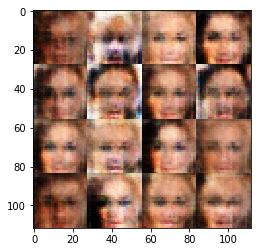

Epoch 0/2... Discriminator Loss: 1.5189... Generator Loss: 0.8091
Epoch 0/2... Discriminator Loss: 1.4519... Generator Loss: 0.7752
Epoch 0/2... Discriminator Loss: 1.4428... Generator Loss: 0.8272
Epoch 0/2... Discriminator Loss: 1.3692... Generator Loss: 0.8306
Epoch 0/2... Discriminator Loss: 1.4442... Generator Loss: 0.7670
Epoch 0/2... Discriminator Loss: 1.4603... Generator Loss: 0.7561
Epoch 0/2... Discriminator Loss: 1.4710... Generator Loss: 0.8486
Epoch 0/2... Discriminator Loss: 1.4025... Generator Loss: 0.8361
Epoch 0/2... Discriminator Loss: 1.4724... Generator Loss: 0.6813
Epoch 0/2... Discriminator Loss: 1.4998... Generator Loss: 0.7665
Epoch 0/2... Discriminator Loss: 1.4707... Generator Loss: 0.8065
Epoch 0/2... Discriminator Loss: 1.3921... Generator Loss: 0.8486
Epoch 0/2... Discriminator Loss: 1.4312... Generator Loss: 0.7569
Epoch 0/2... Discriminator Loss: 1.3945... Generator Loss: 0.7534
Epoch 0/2... Discriminator Loss: 1.4493... Generator Loss: 0.7957
Epoch 0/2.

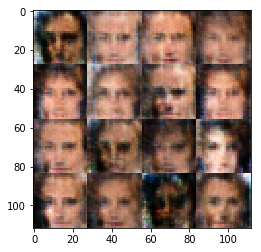

Epoch 0/2... Discriminator Loss: 1.4561... Generator Loss: 0.7790
Epoch 0/2... Discriminator Loss: 1.3957... Generator Loss: 0.7731
Epoch 0/2... Discriminator Loss: 1.4258... Generator Loss: 0.7723
Epoch 0/2... Discriminator Loss: 1.4794... Generator Loss: 0.7643
Epoch 0/2... Discriminator Loss: 1.3843... Generator Loss: 0.7860
Epoch 0/2... Discriminator Loss: 1.4889... Generator Loss: 0.8167
Epoch 0/2... Discriminator Loss: 1.4143... Generator Loss: 0.8411
Epoch 0/2... Discriminator Loss: 1.3944... Generator Loss: 0.8505
Epoch 0/2... Discriminator Loss: 1.4229... Generator Loss: 0.7432
Epoch 0/2... Discriminator Loss: 1.4289... Generator Loss: 0.7483
Epoch 0/2... Discriminator Loss: 1.4508... Generator Loss: 0.7522
Epoch 0/2... Discriminator Loss: 1.4761... Generator Loss: 0.8637
Epoch 0/2... Discriminator Loss: 1.4615... Generator Loss: 0.7709
Epoch 0/2... Discriminator Loss: 1.4334... Generator Loss: 0.7498
Epoch 0/2... Discriminator Loss: 1.4374... Generator Loss: 0.7240
Epoch 0/2.

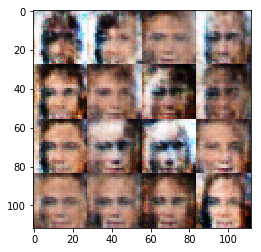

Epoch 0/2... Discriminator Loss: 1.4611... Generator Loss: 0.7456
Epoch 0/2... Discriminator Loss: 1.4023... Generator Loss: 0.7296
Epoch 0/2... Discriminator Loss: 1.4169... Generator Loss: 0.7314
Epoch 0/2... Discriminator Loss: 1.4435... Generator Loss: 0.7684
Epoch 0/2... Discriminator Loss: 1.4821... Generator Loss: 0.6863
Epoch 0/2... Discriminator Loss: 1.4824... Generator Loss: 0.7406
Epoch 0/2... Discriminator Loss: 1.4314... Generator Loss: 0.7581
Epoch 0/2... Discriminator Loss: 1.4144... Generator Loss: 0.7814
Epoch 0/2... Discriminator Loss: 1.3761... Generator Loss: 0.7980
Epoch 0/2... Discriminator Loss: 1.4442... Generator Loss: 0.7668
Epoch 0/2... Discriminator Loss: 1.4260... Generator Loss: 0.7413
Epoch 0/2... Discriminator Loss: 1.4071... Generator Loss: 0.7456
Epoch 0/2... Discriminator Loss: 1.4625... Generator Loss: 0.7105
Epoch 0/2... Discriminator Loss: 1.4214... Generator Loss: 0.8269
Epoch 0/2... Discriminator Loss: 1.4449... Generator Loss: 0.7770
Epoch 0/2.

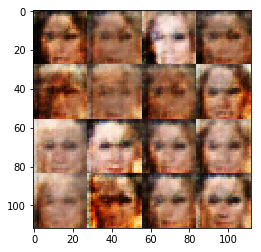

Epoch 0/2... Discriminator Loss: 1.3504... Generator Loss: 0.7744
Epoch 0/2... Discriminator Loss: 1.4050... Generator Loss: 0.7801
Epoch 0/2... Discriminator Loss: 1.4739... Generator Loss: 0.7894
Epoch 0/2... Discriminator Loss: 1.4155... Generator Loss: 0.8233
Epoch 0/2... Discriminator Loss: 1.4665... Generator Loss: 0.7901
Epoch 0/2... Discriminator Loss: 1.4230... Generator Loss: 0.7410
Epoch 0/2... Discriminator Loss: 1.4590... Generator Loss: 0.7735
Epoch 0/2... Discriminator Loss: 1.3944... Generator Loss: 0.7307
Epoch 0/2... Discriminator Loss: 1.3838... Generator Loss: 0.8146
Epoch 0/2... Discriminator Loss: 1.4341... Generator Loss: 0.7633
Epoch 0/2... Discriminator Loss: 1.4501... Generator Loss: 0.7940
Epoch 0/2... Discriminator Loss: 1.3843... Generator Loss: 0.7679
Epoch 0/2... Discriminator Loss: 1.4329... Generator Loss: 0.8496
Epoch 0/2... Discriminator Loss: 1.4228... Generator Loss: 0.7883
Epoch 0/2... Discriminator Loss: 1.4210... Generator Loss: 0.7505
Epoch 0/2.

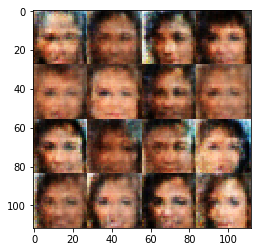

Epoch 0/2... Discriminator Loss: 1.4730... Generator Loss: 0.7339
Epoch 0/2... Discriminator Loss: 1.4165... Generator Loss: 0.7235
Epoch 0/2... Discriminator Loss: 1.3774... Generator Loss: 0.8096
Epoch 0/2... Discriminator Loss: 1.4008... Generator Loss: 0.8279
Epoch 0/2... Discriminator Loss: 1.4395... Generator Loss: 0.7562
Epoch 0/2... Discriminator Loss: 1.4984... Generator Loss: 0.7865
Epoch 0/2... Discriminator Loss: 1.4453... Generator Loss: 0.7435
Epoch 0/2... Discriminator Loss: 1.4175... Generator Loss: 0.8082
Epoch 0/2... Discriminator Loss: 1.4543... Generator Loss: 0.8620
Epoch 0/2... Discriminator Loss: 1.4510... Generator Loss: 0.7531
Epoch 0/2... Discriminator Loss: 1.4089... Generator Loss: 0.8040
Epoch 0/2... Discriminator Loss: 1.3849... Generator Loss: 0.7439
Epoch 0/2... Discriminator Loss: 1.4590... Generator Loss: 0.7882
Epoch 0/2... Discriminator Loss: 1.4245... Generator Loss: 0.7895
Epoch 0/2... Discriminator Loss: 1.4060... Generator Loss: 0.7472
Epoch 0/2.

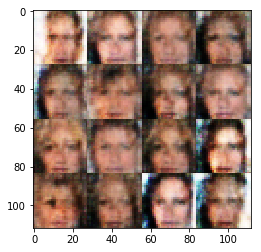

Epoch 0/2... Discriminator Loss: 1.3820... Generator Loss: 0.7820
Epoch 0/2... Discriminator Loss: 1.3879... Generator Loss: 0.7995
Epoch 0/2... Discriminator Loss: 1.4004... Generator Loss: 0.7419
Epoch 0/2... Discriminator Loss: 1.4189... Generator Loss: 0.8672
Epoch 0/2... Discriminator Loss: 1.4018... Generator Loss: 0.8878
Epoch 0/2... Discriminator Loss: 1.3871... Generator Loss: 0.7451
Epoch 0/2... Discriminator Loss: 1.3754... Generator Loss: 0.8617
Epoch 0/2... Discriminator Loss: 1.3918... Generator Loss: 0.7509
Epoch 0/2... Discriminator Loss: 1.4149... Generator Loss: 0.7655
Epoch 0/2... Discriminator Loss: 1.3957... Generator Loss: 0.7817
Epoch 0/2... Discriminator Loss: 1.4052... Generator Loss: 0.7605
Epoch 0/2... Discriminator Loss: 1.4226... Generator Loss: 0.7623
Epoch 0/2... Discriminator Loss: 1.4146... Generator Loss: 0.7558
Epoch 0/2... Discriminator Loss: 1.3697... Generator Loss: 0.8048
Epoch 0/2... Discriminator Loss: 1.4090... Generator Loss: 0.7669
Epoch 0/2.

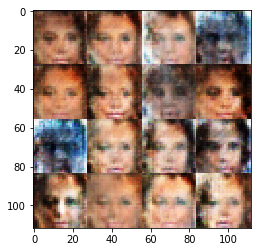

Epoch 0/2... Discriminator Loss: 1.4090... Generator Loss: 0.7193
Epoch 0/2... Discriminator Loss: 1.4368... Generator Loss: 0.8228
Epoch 0/2... Discriminator Loss: 1.4492... Generator Loss: 0.8000
Epoch 0/2... Discriminator Loss: 1.4268... Generator Loss: 0.7127
Epoch 0/2... Discriminator Loss: 1.4480... Generator Loss: 0.7637
Epoch 0/2... Discriminator Loss: 1.3938... Generator Loss: 0.8266
Epoch 0/2... Discriminator Loss: 1.4220... Generator Loss: 0.7933
Epoch 0/2... Discriminator Loss: 1.3954... Generator Loss: 0.8197
Epoch 0/2... Discriminator Loss: 1.4450... Generator Loss: 0.8010
Epoch 0/2... Discriminator Loss: 1.3781... Generator Loss: 0.7770
Epoch 0/2... Discriminator Loss: 1.3527... Generator Loss: 0.8113
Epoch 0/2... Discriminator Loss: 1.3962... Generator Loss: 0.7167
Epoch 0/2... Discriminator Loss: 1.3775... Generator Loss: 0.7688
Epoch 0/2... Discriminator Loss: 1.3760... Generator Loss: 0.7960
Epoch 0/2... Discriminator Loss: 1.3785... Generator Loss: 0.7726
Epoch 0/2.

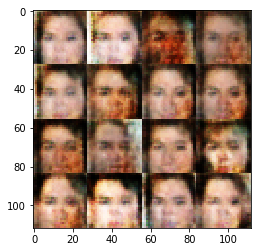

Epoch 0/2... Discriminator Loss: 1.3540... Generator Loss: 0.8383
Epoch 0/2... Discriminator Loss: 1.4406... Generator Loss: 0.7406
Epoch 0/2... Discriminator Loss: 1.4276... Generator Loss: 0.8287
Epoch 0/2... Discriminator Loss: 1.3848... Generator Loss: 0.7918
Epoch 0/2... Discriminator Loss: 1.4270... Generator Loss: 0.7926
Epoch 0/2... Discriminator Loss: 1.4133... Generator Loss: 0.7512
Epoch 0/2... Discriminator Loss: 1.3900... Generator Loss: 0.8217
Epoch 0/2... Discriminator Loss: 1.3766... Generator Loss: 0.7621
Epoch 0/2... Discriminator Loss: 1.4306... Generator Loss: 0.7449
Epoch 0/2... Discriminator Loss: 1.4386... Generator Loss: 0.7921
Epoch 0/2... Discriminator Loss: 1.4190... Generator Loss: 0.8132
Epoch 0/2... Discriminator Loss: 1.4172... Generator Loss: 0.7627
Epoch 0/2... Discriminator Loss: 1.4396... Generator Loss: 0.8059
Epoch 0/2... Discriminator Loss: 1.4262... Generator Loss: 0.7320
Epoch 0/2... Discriminator Loss: 1.4248... Generator Loss: 0.8207
Epoch 0/2.

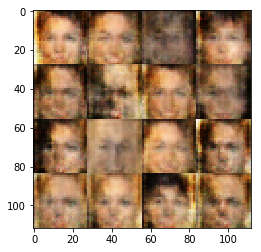

Epoch 0/2... Discriminator Loss: 1.3990... Generator Loss: 0.7750
Epoch 0/2... Discriminator Loss: 1.3844... Generator Loss: 0.7265
Epoch 0/2... Discriminator Loss: 1.4173... Generator Loss: 0.7586
Epoch 0/2... Discriminator Loss: 1.3911... Generator Loss: 0.8810
Epoch 0/2... Discriminator Loss: 1.4336... Generator Loss: 0.7834
Epoch 0/2... Discriminator Loss: 1.3915... Generator Loss: 0.7057
Epoch 0/2... Discriminator Loss: 1.3626... Generator Loss: 0.8278
Epoch 0/2... Discriminator Loss: 1.3994... Generator Loss: 0.7661
Epoch 0/2... Discriminator Loss: 1.3775... Generator Loss: 0.7659
Epoch 0/2... Discriminator Loss: 1.3938... Generator Loss: 0.7808
Epoch 0/2... Discriminator Loss: 1.4685... Generator Loss: 0.7444
Epoch 0/2... Discriminator Loss: 1.3881... Generator Loss: 0.8247
Epoch 0/2... Discriminator Loss: 1.4123... Generator Loss: 0.7698
Epoch 0/2... Discriminator Loss: 1.4080... Generator Loss: 0.7805
Epoch 0/2... Discriminator Loss: 1.3591... Generator Loss: 0.8178
Epoch 0/2.

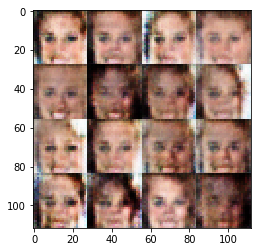

Epoch 0/2... Discriminator Loss: 1.4158... Generator Loss: 0.8019
Epoch 0/2... Discriminator Loss: 1.4028... Generator Loss: 0.8460
Epoch 0/2... Discriminator Loss: 1.4021... Generator Loss: 0.7480
Epoch 0/2... Discriminator Loss: 1.4267... Generator Loss: 0.8124
Epoch 0/2... Discriminator Loss: 1.3610... Generator Loss: 0.8036
Epoch 0/2... Discriminator Loss: 1.4096... Generator Loss: 0.7845
Epoch 0/2... Discriminator Loss: 1.4081... Generator Loss: 0.8042
Epoch 0/2... Discriminator Loss: 1.3856... Generator Loss: 0.7984
Epoch 0/2... Discriminator Loss: 1.4157... Generator Loss: 0.7622
Epoch 0/2... Discriminator Loss: 1.4239... Generator Loss: 0.8263
Epoch 0/2... Discriminator Loss: 1.3898... Generator Loss: 0.7462
Epoch 0/2... Discriminator Loss: 1.4027... Generator Loss: 0.8081
Epoch 0/2... Discriminator Loss: 1.3680... Generator Loss: 0.8150
Epoch 0/2... Discriminator Loss: 1.4151... Generator Loss: 0.8371
Epoch 0/2... Discriminator Loss: 1.3868... Generator Loss: 0.7519
Epoch 0/2.

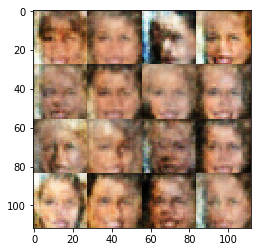

Epoch 0/2... Discriminator Loss: 1.3836... Generator Loss: 0.7374
Epoch 0/2... Discriminator Loss: 1.3748... Generator Loss: 0.7718
Epoch 0/2... Discriminator Loss: 1.4084... Generator Loss: 0.7894
Epoch 0/2... Discriminator Loss: 1.4091... Generator Loss: 0.7825
Epoch 0/2... Discriminator Loss: 1.4178... Generator Loss: 0.7068
Epoch 0/2... Discriminator Loss: 1.4074... Generator Loss: 0.8272
Epoch 0/2... Discriminator Loss: 1.3948... Generator Loss: 0.8195
Epoch 0/2... Discriminator Loss: 1.4329... Generator Loss: 0.7969
Epoch 0/2... Discriminator Loss: 1.3632... Generator Loss: 0.8069
Epoch 0/2... Discriminator Loss: 1.4037... Generator Loss: 0.7636
Epoch 0/2... Discriminator Loss: 1.3827... Generator Loss: 0.7681
Epoch 0/2... Discriminator Loss: 1.4250... Generator Loss: 0.7267
Epoch 0/2... Discriminator Loss: 1.3845... Generator Loss: 0.8060
Epoch 0/2... Discriminator Loss: 1.3824... Generator Loss: 0.7761
Epoch 0/2... Discriminator Loss: 1.4033... Generator Loss: 0.7917
Epoch 0/2.

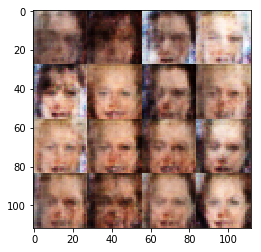

Epoch 0/2... Discriminator Loss: 1.4153... Generator Loss: 0.7755
Epoch 0/2... Discriminator Loss: 1.4277... Generator Loss: 0.8164
Epoch 0/2... Discriminator Loss: 1.3960... Generator Loss: 0.8109
Epoch 0/2... Discriminator Loss: 1.4237... Generator Loss: 0.7708
Epoch 0/2... Discriminator Loss: 1.3852... Generator Loss: 0.7357
Epoch 0/2... Discriminator Loss: 1.4010... Generator Loss: 0.7450
Epoch 0/2... Discriminator Loss: 1.4044... Generator Loss: 0.7369
Epoch 0/2... Discriminator Loss: 1.4050... Generator Loss: 0.7944
Epoch 0/2... Discriminator Loss: 1.3830... Generator Loss: 0.7312
Epoch 0/2... Discriminator Loss: 1.4194... Generator Loss: 0.8332
Epoch 0/2... Discriminator Loss: 1.3905... Generator Loss: 0.8227
Epoch 0/2... Discriminator Loss: 1.4056... Generator Loss: 0.7439
Epoch 0/2... Discriminator Loss: 1.4130... Generator Loss: 0.7090
Epoch 0/2... Discriminator Loss: 1.4037... Generator Loss: 0.7598
Epoch 0/2... Discriminator Loss: 1.4288... Generator Loss: 0.7563
Epoch 0/2.

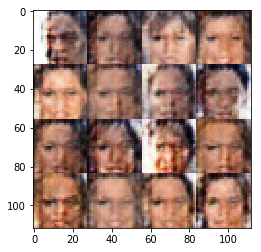

Epoch 0/2... Discriminator Loss: 1.4077... Generator Loss: 0.7649
Epoch 0/2... Discriminator Loss: 1.3730... Generator Loss: 0.7711
Epoch 0/2... Discriminator Loss: 1.4072... Generator Loss: 0.7270
Epoch 0/2... Discriminator Loss: 1.4097... Generator Loss: 0.7980
Epoch 0/2... Discriminator Loss: 1.4307... Generator Loss: 0.7247
Epoch 0/2... Discriminator Loss: 1.3956... Generator Loss: 0.7610
Epoch 0/2... Discriminator Loss: 1.3851... Generator Loss: 0.7350
Epoch 0/2... Discriminator Loss: 1.4118... Generator Loss: 0.7588
Epoch 0/2... Discriminator Loss: 1.3677... Generator Loss: 0.8399
Epoch 0/2... Discriminator Loss: 1.4028... Generator Loss: 0.8560
Epoch 0/2... Discriminator Loss: 1.4410... Generator Loss: 0.8243
Epoch 0/2... Discriminator Loss: 1.4124... Generator Loss: 0.7860
Epoch 0/2... Discriminator Loss: 1.3902... Generator Loss: 0.8378
Epoch 0/2... Discriminator Loss: 1.3506... Generator Loss: 0.8416
Epoch 0/2... Discriminator Loss: 1.3990... Generator Loss: 0.8380
Epoch 0/2.

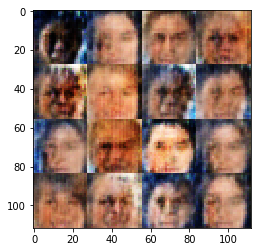

Epoch 0/2... Discriminator Loss: 1.4051... Generator Loss: 0.7499
Epoch 0/2... Discriminator Loss: 1.3754... Generator Loss: 0.7777
Epoch 0/2... Discriminator Loss: 1.3891... Generator Loss: 0.8053
Epoch 0/2... Discriminator Loss: 1.3740... Generator Loss: 0.7981
Epoch 0/2... Discriminator Loss: 1.4094... Generator Loss: 0.7235
Epoch 0/2... Discriminator Loss: 1.4235... Generator Loss: 0.7859
Epoch 0/2... Discriminator Loss: 1.3748... Generator Loss: 0.7474
Epoch 0/2... Discriminator Loss: 1.3838... Generator Loss: 0.7726
Epoch 0/2... Discriminator Loss: 1.3637... Generator Loss: 0.8408
Epoch 0/2... Discriminator Loss: 1.3957... Generator Loss: 0.8185
Epoch 0/2... Discriminator Loss: 1.3947... Generator Loss: 0.8576
Epoch 0/2... Discriminator Loss: 1.4201... Generator Loss: 0.8154
Epoch 0/2... Discriminator Loss: 1.4064... Generator Loss: 0.7881
Epoch 0/2... Discriminator Loss: 1.4021... Generator Loss: 0.8141
Epoch 0/2... Discriminator Loss: 1.4264... Generator Loss: 0.8244
Epoch 0/2.

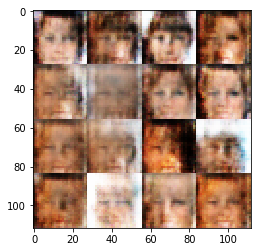

Epoch 0/2... Discriminator Loss: 1.4056... Generator Loss: 0.7828
Epoch 0/2... Discriminator Loss: 1.4221... Generator Loss: 0.7811
Epoch 0/2... Discriminator Loss: 1.4030... Generator Loss: 0.7954
Epoch 0/2... Discriminator Loss: 1.3401... Generator Loss: 0.8086
Epoch 0/2... Discriminator Loss: 1.4076... Generator Loss: 0.7954
Epoch 0/2... Discriminator Loss: 1.4003... Generator Loss: 0.8360
Epoch 0/2... Discriminator Loss: 1.3942... Generator Loss: 0.7649
Epoch 0/2... Discriminator Loss: 1.3582... Generator Loss: 0.7902
Epoch 0/2... Discriminator Loss: 1.4027... Generator Loss: 0.7812
Epoch 0/2... Discriminator Loss: 1.4190... Generator Loss: 0.7920
Epoch 0/2... Discriminator Loss: 1.4116... Generator Loss: 0.7459
Epoch 0/2... Discriminator Loss: 1.4149... Generator Loss: 0.8064
Epoch 0/2... Discriminator Loss: 1.3880... Generator Loss: 0.7979
Epoch 0/2... Discriminator Loss: 1.3991... Generator Loss: 0.8989
Epoch 0/2... Discriminator Loss: 1.4142... Generator Loss: 0.7791
Epoch 0/2.

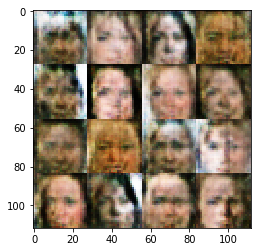

Epoch 0/2... Discriminator Loss: 1.4053... Generator Loss: 0.7707
Epoch 0/2... Discriminator Loss: 1.4118... Generator Loss: 0.7994
Epoch 0/2... Discriminator Loss: 1.4404... Generator Loss: 0.9032
Epoch 0/2... Discriminator Loss: 1.3648... Generator Loss: 0.7924
Epoch 0/2... Discriminator Loss: 1.3904... Generator Loss: 0.7357
Epoch 0/2... Discriminator Loss: 1.3779... Generator Loss: 0.7511
Epoch 0/2... Discriminator Loss: 1.4089... Generator Loss: 0.7646
Epoch 0/2... Discriminator Loss: 1.4392... Generator Loss: 0.7994
Epoch 0/2... Discriminator Loss: 1.4226... Generator Loss: 0.7819
Epoch 0/2... Discriminator Loss: 1.3861... Generator Loss: 0.8017
Epoch 0/2... Discriminator Loss: 1.3886... Generator Loss: 0.7708
Epoch 0/2... Discriminator Loss: 1.3754... Generator Loss: 0.8082
Epoch 0/2... Discriminator Loss: 1.3961... Generator Loss: 0.7289
Epoch 0/2... Discriminator Loss: 1.4078... Generator Loss: 0.7369
Epoch 0/2... Discriminator Loss: 1.3895... Generator Loss: 0.7525
Epoch 0/2.

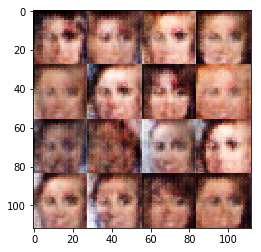

Epoch 0/2... Discriminator Loss: 1.3898... Generator Loss: 0.7731
Epoch 0/2... Discriminator Loss: 1.3914... Generator Loss: 0.8032
Epoch 0/2... Discriminator Loss: 1.3614... Generator Loss: 0.8300
Epoch 0/2... Discriminator Loss: 1.3807... Generator Loss: 0.8077
Epoch 0/2... Discriminator Loss: 1.4124... Generator Loss: 0.7930
Epoch 0/2... Discriminator Loss: 1.4060... Generator Loss: 0.8116
Epoch 0/2... Discriminator Loss: 1.3920... Generator Loss: 0.7949
Epoch 0/2... Discriminator Loss: 1.3534... Generator Loss: 0.7978
Epoch 0/2... Discriminator Loss: 1.4097... Generator Loss: 0.7710
Epoch 0/2... Discriminator Loss: 1.4247... Generator Loss: 0.7915
Epoch 0/2... Discriminator Loss: 1.3757... Generator Loss: 0.8014
Epoch 0/2... Discriminator Loss: 1.4192... Generator Loss: 0.8212
Epoch 0/2... Discriminator Loss: 1.3999... Generator Loss: 0.7749
Epoch 0/2... Discriminator Loss: 1.4017... Generator Loss: 0.8287
Epoch 0/2... Discriminator Loss: 1.3933... Generator Loss: 0.8175
Epoch 0/2.

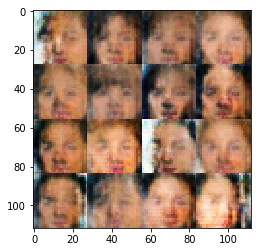

Epoch 0/2... Discriminator Loss: 1.4011... Generator Loss: 0.8379
Epoch 0/2... Discriminator Loss: 1.3878... Generator Loss: 0.8343
Epoch 0/2... Discriminator Loss: 1.4013... Generator Loss: 0.8204
Epoch 0/2... Discriminator Loss: 1.4091... Generator Loss: 0.7805
Epoch 0/2... Discriminator Loss: 1.3890... Generator Loss: 0.7359
Epoch 0/2... Discriminator Loss: 1.4151... Generator Loss: 0.7887
Epoch 0/2... Discriminator Loss: 1.4113... Generator Loss: 0.8027
Epoch 0/2... Discriminator Loss: 1.4087... Generator Loss: 0.8145
Epoch 0/2... Discriminator Loss: 1.3877... Generator Loss: 0.8839
Epoch 0/2... Discriminator Loss: 1.4193... Generator Loss: 0.7673
Epoch 0/2... Discriminator Loss: 1.3679... Generator Loss: 0.8136
Epoch 0/2... Discriminator Loss: 1.3854... Generator Loss: 0.7662
Epoch 0/2... Discriminator Loss: 1.4139... Generator Loss: 0.8382
Epoch 0/2... Discriminator Loss: 1.4338... Generator Loss: 0.7893
Epoch 0/2... Discriminator Loss: 1.4218... Generator Loss: 0.7904
Epoch 0/2.

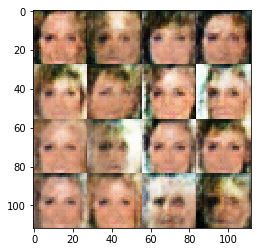

Epoch 0/2... Discriminator Loss: 1.3977... Generator Loss: 0.7878
Epoch 0/2... Discriminator Loss: 1.3942... Generator Loss: 0.7491
Epoch 0/2... Discriminator Loss: 1.4274... Generator Loss: 0.8083
Epoch 0/2... Discriminator Loss: 1.4239... Generator Loss: 0.8116
Epoch 0/2... Discriminator Loss: 1.3656... Generator Loss: 0.7841
Epoch 0/2... Discriminator Loss: 1.4024... Generator Loss: 0.8905
Epoch 0/2... Discriminator Loss: 1.3951... Generator Loss: 0.7959
Epoch 0/2... Discriminator Loss: 1.3934... Generator Loss: 0.7693
Epoch 0/2... Discriminator Loss: 1.3779... Generator Loss: 0.7306
Epoch 0/2... Discriminator Loss: 1.3848... Generator Loss: 0.7749
Epoch 0/2... Discriminator Loss: 1.3747... Generator Loss: 0.8949
Epoch 0/2... Discriminator Loss: 1.4713... Generator Loss: 0.7852
Epoch 0/2... Discriminator Loss: 1.3847... Generator Loss: 0.7371
Epoch 0/2... Discriminator Loss: 1.3967... Generator Loss: 0.8278
Epoch 0/2... Discriminator Loss: 1.4138... Generator Loss: 0.7490
Epoch 0/2.

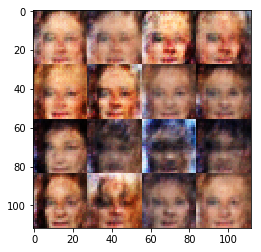

Epoch 0/2... Discriminator Loss: 1.3917... Generator Loss: 0.8084
Epoch 0/2... Discriminator Loss: 1.4000... Generator Loss: 0.7534
Epoch 0/2... Discriminator Loss: 1.3797... Generator Loss: 0.7896
Epoch 0/2... Discriminator Loss: 1.3690... Generator Loss: 0.8353
Epoch 0/2... Discriminator Loss: 1.3822... Generator Loss: 0.8556
Epoch 0/2... Discriminator Loss: 1.3961... Generator Loss: 0.7599
Epoch 0/2... Discriminator Loss: 1.3801... Generator Loss: 0.7741
Epoch 0/2... Discriminator Loss: 1.4002... Generator Loss: 0.7718
Epoch 0/2... Discriminator Loss: 1.4213... Generator Loss: 0.7452
Epoch 0/2... Discriminator Loss: 1.3779... Generator Loss: 0.7915
Epoch 0/2... Discriminator Loss: 1.3839... Generator Loss: 0.8518
Epoch 0/2... Discriminator Loss: 1.3625... Generator Loss: 0.7938
Epoch 0/2... Discriminator Loss: 1.4007... Generator Loss: 0.8567
Epoch 0/2... Discriminator Loss: 1.3951... Generator Loss: 0.8204
Epoch 0/2... Discriminator Loss: 1.4111... Generator Loss: 0.7700
Epoch 0/2.

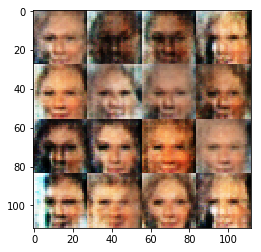

Epoch 0/2... Discriminator Loss: 1.3799... Generator Loss: 0.7979
Epoch 0/2... Discriminator Loss: 1.3899... Generator Loss: 0.7711
Epoch 0/2... Discriminator Loss: 1.4159... Generator Loss: 0.7577
Epoch 0/2... Discriminator Loss: 1.4125... Generator Loss: 0.7923
Epoch 0/2... Discriminator Loss: 1.4167... Generator Loss: 0.8243
Epoch 0/2... Discriminator Loss: 1.3837... Generator Loss: 0.7478
Epoch 0/2... Discriminator Loss: 1.4037... Generator Loss: 0.8300
Epoch 0/2... Discriminator Loss: 1.3962... Generator Loss: 0.8021
Epoch 0/2... Discriminator Loss: 1.3806... Generator Loss: 0.7537
Epoch 0/2... Discriminator Loss: 1.3897... Generator Loss: 0.7648
Epoch 0/2... Discriminator Loss: 1.4375... Generator Loss: 0.7570
Epoch 0/2... Discriminator Loss: 1.4104... Generator Loss: 0.7289
Epoch 0/2... Discriminator Loss: 1.3930... Generator Loss: 0.8167
Epoch 0/2... Discriminator Loss: 1.3857... Generator Loss: 0.7589
Epoch 0/2... Discriminator Loss: 1.4013... Generator Loss: 0.7896
Epoch 0/2.

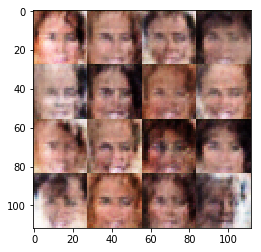

Epoch 0/2... Discriminator Loss: 1.3692... Generator Loss: 0.7649
Epoch 0/2... Discriminator Loss: 1.4029... Generator Loss: 0.8248
Epoch 0/2... Discriminator Loss: 1.4099... Generator Loss: 0.8212
Epoch 0/2... Discriminator Loss: 1.3789... Generator Loss: 0.7663
Epoch 0/2... Discriminator Loss: 1.3954... Generator Loss: 0.7437
Epoch 0/2... Discriminator Loss: 1.3705... Generator Loss: 0.7782
Epoch 0/2... Discriminator Loss: 1.4140... Generator Loss: 0.7384
Epoch 0/2... Discriminator Loss: 1.3849... Generator Loss: 0.7412
Epoch 0/2... Discriminator Loss: 1.4435... Generator Loss: 0.7295
Epoch 0/2... Discriminator Loss: 1.3945... Generator Loss: 0.8328
Epoch 0/2... Discriminator Loss: 1.4122... Generator Loss: 0.7528
Epoch 0/2... Discriminator Loss: 1.3940... Generator Loss: 0.8132
Epoch 0/2... Discriminator Loss: 1.4254... Generator Loss: 0.8542
Epoch 0/2... Discriminator Loss: 1.4292... Generator Loss: 0.7390
Epoch 0/2... Discriminator Loss: 1.3883... Generator Loss: 0.7732
Epoch 0/2.

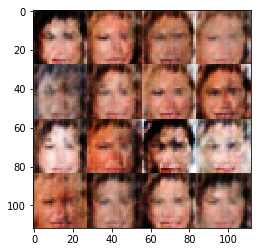

Epoch 0/2... Discriminator Loss: 1.4036... Generator Loss: 0.8303
Epoch 0/2... Discriminator Loss: 1.3817... Generator Loss: 0.8253
Epoch 0/2... Discriminator Loss: 1.3834... Generator Loss: 0.8019
Epoch 0/2... Discriminator Loss: 1.3974... Generator Loss: 0.8111
Epoch 0/2... Discriminator Loss: 1.3806... Generator Loss: 0.8134
Epoch 0/2... Discriminator Loss: 1.4571... Generator Loss: 0.7449
Epoch 0/2... Discriminator Loss: 1.4089... Generator Loss: 0.7637
Epoch 0/2... Discriminator Loss: 1.4038... Generator Loss: 0.7977
Epoch 0/2... Discriminator Loss: 1.3558... Generator Loss: 0.8106
Epoch 0/2... Discriminator Loss: 1.3942... Generator Loss: 0.8126
Epoch 0/2... Discriminator Loss: 1.3829... Generator Loss: 0.7934
Epoch 0/2... Discriminator Loss: 1.3983... Generator Loss: 0.7930
Epoch 0/2... Discriminator Loss: 1.4005... Generator Loss: 0.7497
Epoch 0/2... Discriminator Loss: 1.3719... Generator Loss: 0.7624
Epoch 0/2... Discriminator Loss: 1.4047... Generator Loss: 0.8627
Epoch 0/2.

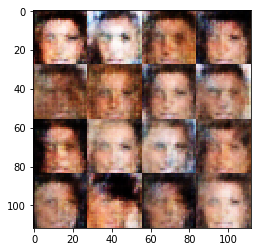

Epoch 0/2... Discriminator Loss: 1.4256... Generator Loss: 0.7071
Epoch 0/2... Discriminator Loss: 1.3933... Generator Loss: 0.8032
Epoch 0/2... Discriminator Loss: 1.4188... Generator Loss: 0.7020
Epoch 0/2... Discriminator Loss: 1.3913... Generator Loss: 0.7367
Epoch 0/2... Discriminator Loss: 1.3790... Generator Loss: 0.7362
Epoch 0/2... Discriminator Loss: 1.3842... Generator Loss: 0.7867
Epoch 0/2... Discriminator Loss: 1.3770... Generator Loss: 0.8071
Epoch 0/2... Discriminator Loss: 1.3886... Generator Loss: 0.8004
Epoch 0/2... Discriminator Loss: 1.3860... Generator Loss: 0.7865
Epoch 0/2... Discriminator Loss: 1.3747... Generator Loss: 0.8792
Epoch 0/2... Discriminator Loss: 1.3669... Generator Loss: 0.7679
Epoch 0/2... Discriminator Loss: 1.3982... Generator Loss: 0.8006
Epoch 0/2... Discriminator Loss: 1.4202... Generator Loss: 0.7472
Epoch 1/2... Discriminator Loss: 1.4142... Generator Loss: 0.7651
Epoch 1/2... Discriminator Loss: 1.4037... Generator Loss: 0.7875
Epoch 1/2.

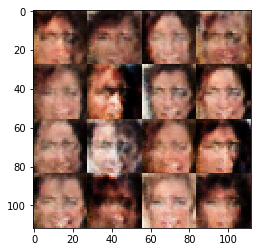

Epoch 1/2... Discriminator Loss: 1.4197... Generator Loss: 0.7797
Epoch 1/2... Discriminator Loss: 1.3956... Generator Loss: 0.8017
Epoch 1/2... Discriminator Loss: 1.3894... Generator Loss: 0.7560
Epoch 1/2... Discriminator Loss: 1.3822... Generator Loss: 0.7794
Epoch 1/2... Discriminator Loss: 1.3949... Generator Loss: 0.8295
Epoch 1/2... Discriminator Loss: 1.3849... Generator Loss: 0.7466
Epoch 1/2... Discriminator Loss: 1.3844... Generator Loss: 0.8016
Epoch 1/2... Discriminator Loss: 1.4065... Generator Loss: 0.7707
Epoch 1/2... Discriminator Loss: 1.3895... Generator Loss: 0.8442
Epoch 1/2... Discriminator Loss: 1.4200... Generator Loss: 0.8633
Epoch 1/2... Discriminator Loss: 1.4276... Generator Loss: 0.8230
Epoch 1/2... Discriminator Loss: 1.3801... Generator Loss: 0.8139
Epoch 1/2... Discriminator Loss: 1.3933... Generator Loss: 0.7701
Epoch 1/2... Discriminator Loss: 1.3860... Generator Loss: 0.8112
Epoch 1/2... Discriminator Loss: 1.3751... Generator Loss: 0.8146
Epoch 1/2.

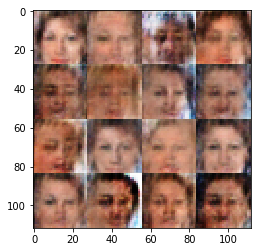

Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 0.7697
Epoch 1/2... Discriminator Loss: 1.3987... Generator Loss: 0.8376
Epoch 1/2... Discriminator Loss: 1.3981... Generator Loss: 0.8034
Epoch 1/2... Discriminator Loss: 1.4243... Generator Loss: 0.7921
Epoch 1/2... Discriminator Loss: 1.3795... Generator Loss: 0.7454
Epoch 1/2... Discriminator Loss: 1.3979... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 0.8066
Epoch 1/2... Discriminator Loss: 1.3806... Generator Loss: 0.8105
Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 0.8081
Epoch 1/2... Discriminator Loss: 1.3625... Generator Loss: 0.7330
Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 0.8749
Epoch 1/2... Discriminator Loss: 1.3928... Generator Loss: 0.6863
Epoch 1/2... Discriminator Loss: 1.3955... Generator Loss: 0.7535
Epoch 1/2... Discriminator Loss: 1.3967... Generator Loss: 0.7771
Epoch 1/2... Discriminator Loss: 1.3881... Generator Loss: 0.7448
Epoch 1/2.

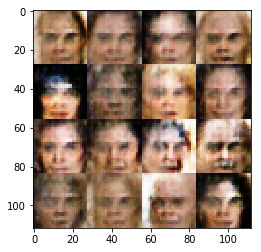

Epoch 1/2... Discriminator Loss: 1.3956... Generator Loss: 0.8117
Epoch 1/2... Discriminator Loss: 1.3835... Generator Loss: 0.8308
Epoch 1/2... Discriminator Loss: 1.3918... Generator Loss: 0.8478
Epoch 1/2... Discriminator Loss: 1.4047... Generator Loss: 0.7551
Epoch 1/2... Discriminator Loss: 1.3983... Generator Loss: 0.7542
Epoch 1/2... Discriminator Loss: 1.3959... Generator Loss: 0.7658
Epoch 1/2... Discriminator Loss: 1.4147... Generator Loss: 0.7612
Epoch 1/2... Discriminator Loss: 1.4113... Generator Loss: 0.8007
Epoch 1/2... Discriminator Loss: 1.3776... Generator Loss: 0.8103
Epoch 1/2... Discriminator Loss: 1.3918... Generator Loss: 0.7149
Epoch 1/2... Discriminator Loss: 1.3854... Generator Loss: 0.7667
Epoch 1/2... Discriminator Loss: 1.3836... Generator Loss: 0.7824
Epoch 1/2... Discriminator Loss: 1.3878... Generator Loss: 0.7878
Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 0.8378
Epoch 1/2... Discriminator Loss: 1.4082... Generator Loss: 0.7717
Epoch 1/2.

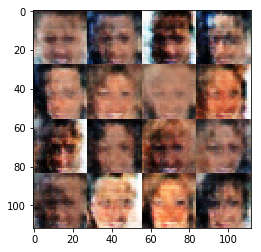

Epoch 1/2... Discriminator Loss: 1.4088... Generator Loss: 0.7797
Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 0.7677
Epoch 1/2... Discriminator Loss: 1.4374... Generator Loss: 0.7168
Epoch 1/2... Discriminator Loss: 1.4232... Generator Loss: 0.7538
Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 0.7683
Epoch 1/2... Discriminator Loss: 1.3914... Generator Loss: 0.7943
Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 0.7401
Epoch 1/2... Discriminator Loss: 1.3799... Generator Loss: 0.8083
Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 0.7792
Epoch 1/2... Discriminator Loss: 1.3787... Generator Loss: 0.8094
Epoch 1/2... Discriminator Loss: 1.3935... Generator Loss: 0.7978
Epoch 1/2... Discriminator Loss: 1.4329... Generator Loss: 0.8025
Epoch 1/2... Discriminator Loss: 1.3986... Generator Loss: 0.8209
Epoch 1/2... Discriminator Loss: 1.4035... Generator Loss: 0.7691
Epoch 1/2... Discriminator Loss: 1.3964... Generator Loss: 0.8999
Epoch 1/2.

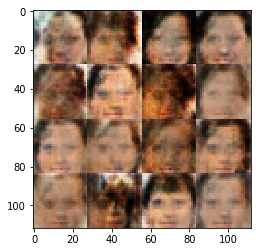

Epoch 1/2... Discriminator Loss: 1.3836... Generator Loss: 0.7416
Epoch 1/2... Discriminator Loss: 1.3960... Generator Loss: 0.8089
Epoch 1/2... Discriminator Loss: 1.4199... Generator Loss: 0.8069
Epoch 1/2... Discriminator Loss: 1.3777... Generator Loss: 0.7456
Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 0.7700
Epoch 1/2... Discriminator Loss: 1.4014... Generator Loss: 0.7703
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.8332
Epoch 1/2... Discriminator Loss: 1.3965... Generator Loss: 0.7910
Epoch 1/2... Discriminator Loss: 1.3938... Generator Loss: 0.7987
Epoch 1/2... Discriminator Loss: 1.4218... Generator Loss: 0.7399
Epoch 1/2... Discriminator Loss: 1.3907... Generator Loss: 0.7811
Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 0.7579
Epoch 1/2... Discriminator Loss: 1.3944... Generator Loss: 0.8950
Epoch 1/2... Discriminator Loss: 1.4283... Generator Loss: 0.7392
Epoch 1/2... Discriminator Loss: 1.3720... Generator Loss: 0.7902
Epoch 1/2.

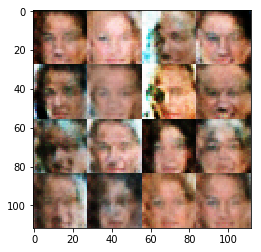

Epoch 1/2... Discriminator Loss: 1.4142... Generator Loss: 0.8445
Epoch 1/2... Discriminator Loss: 1.3750... Generator Loss: 0.8137
Epoch 1/2... Discriminator Loss: 1.3907... Generator Loss: 0.7797
Epoch 1/2... Discriminator Loss: 1.3819... Generator Loss: 0.7698
Epoch 1/2... Discriminator Loss: 1.3593... Generator Loss: 0.7818
Epoch 1/2... Discriminator Loss: 1.3747... Generator Loss: 0.8263
Epoch 1/2... Discriminator Loss: 1.3997... Generator Loss: 0.8118
Epoch 1/2... Discriminator Loss: 1.4134... Generator Loss: 0.7590
Epoch 1/2... Discriminator Loss: 1.3645... Generator Loss: 0.8304
Epoch 1/2... Discriminator Loss: 1.4178... Generator Loss: 0.7717
Epoch 1/2... Discriminator Loss: 1.3481... Generator Loss: 0.7963
Epoch 1/2... Discriminator Loss: 1.4084... Generator Loss: 0.7696
Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 0.7625
Epoch 1/2... Discriminator Loss: 1.3927... Generator Loss: 0.7839
Epoch 1/2... Discriminator Loss: 1.3904... Generator Loss: 0.7799
Epoch 1/2.

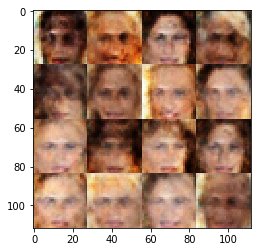

Epoch 1/2... Discriminator Loss: 1.4052... Generator Loss: 0.8041
Epoch 1/2... Discriminator Loss: 1.4199... Generator Loss: 0.8181
Epoch 1/2... Discriminator Loss: 1.3635... Generator Loss: 0.8411
Epoch 1/2... Discriminator Loss: 1.3663... Generator Loss: 0.7409
Epoch 1/2... Discriminator Loss: 1.4139... Generator Loss: 0.8165
Epoch 1/2... Discriminator Loss: 1.3738... Generator Loss: 0.7651
Epoch 1/2... Discriminator Loss: 1.4170... Generator Loss: 0.7912
Epoch 1/2... Discriminator Loss: 1.3811... Generator Loss: 0.7631
Epoch 1/2... Discriminator Loss: 1.3825... Generator Loss: 0.8183
Epoch 1/2... Discriminator Loss: 1.4204... Generator Loss: 0.8253
Epoch 1/2... Discriminator Loss: 1.3957... Generator Loss: 0.7597
Epoch 1/2... Discriminator Loss: 1.3966... Generator Loss: 0.7844
Epoch 1/2... Discriminator Loss: 1.3985... Generator Loss: 0.7671
Epoch 1/2... Discriminator Loss: 1.3861... Generator Loss: 0.8311
Epoch 1/2... Discriminator Loss: 1.3826... Generator Loss: 0.7502
Epoch 1/2.

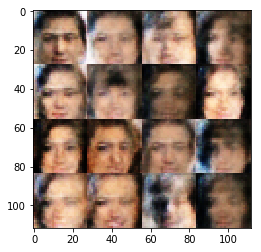

Epoch 1/2... Discriminator Loss: 1.3789... Generator Loss: 0.7651
Epoch 1/2... Discriminator Loss: 1.3798... Generator Loss: 0.7993
Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 0.7602
Epoch 1/2... Discriminator Loss: 1.4152... Generator Loss: 0.7742
Epoch 1/2... Discriminator Loss: 1.3778... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 1.3831... Generator Loss: 0.7243
Epoch 1/2... Discriminator Loss: 1.3873... Generator Loss: 0.7388
Epoch 1/2... Discriminator Loss: 1.4255... Generator Loss: 0.8256
Epoch 1/2... Discriminator Loss: 1.3572... Generator Loss: 0.7786
Epoch 1/2... Discriminator Loss: 1.3884... Generator Loss: 0.8387
Epoch 1/2... Discriminator Loss: 1.4032... Generator Loss: 0.9062
Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 0.7711
Epoch 1/2... Discriminator Loss: 1.3795... Generator Loss: 0.8039
Epoch 1/2... Discriminator Loss: 1.3878... Generator Loss: 0.8327
Epoch 1/2... Discriminator Loss: 1.3858... Generator Loss: 0.7879
Epoch 1/2.

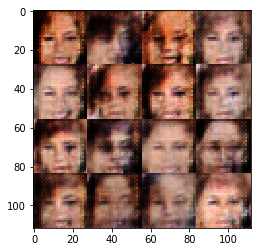

Epoch 1/2... Discriminator Loss: 1.3854... Generator Loss: 0.8372
Epoch 1/2... Discriminator Loss: 1.4011... Generator Loss: 0.7461
Epoch 1/2... Discriminator Loss: 1.4205... Generator Loss: 0.7925
Epoch 1/2... Discriminator Loss: 1.3750... Generator Loss: 0.8029
Epoch 1/2... Discriminator Loss: 1.4252... Generator Loss: 0.7792
Epoch 1/2... Discriminator Loss: 1.3912... Generator Loss: 0.8034
Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 0.7548
Epoch 1/2... Discriminator Loss: 1.3990... Generator Loss: 0.8059
Epoch 1/2... Discriminator Loss: 1.3833... Generator Loss: 0.7682
Epoch 1/2... Discriminator Loss: 1.3666... Generator Loss: 0.8182
Epoch 1/2... Discriminator Loss: 1.3674... Generator Loss: 0.7460
Epoch 1/2... Discriminator Loss: 1.4093... Generator Loss: 0.7535
Epoch 1/2... Discriminator Loss: 1.4021... Generator Loss: 0.7276
Epoch 1/2... Discriminator Loss: 1.3970... Generator Loss: 0.7719
Epoch 1/2... Discriminator Loss: 1.3875... Generator Loss: 0.7561
Epoch 1/2.

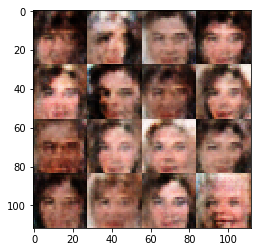

Epoch 1/2... Discriminator Loss: 1.3695... Generator Loss: 0.7790
Epoch 1/2... Discriminator Loss: 1.3920... Generator Loss: 0.8142
Epoch 1/2... Discriminator Loss: 1.3810... Generator Loss: 0.8087
Epoch 1/2... Discriminator Loss: 1.3873... Generator Loss: 0.7159
Epoch 1/2... Discriminator Loss: 1.4077... Generator Loss: 0.7685
Epoch 1/2... Discriminator Loss: 1.4106... Generator Loss: 0.8419
Epoch 1/2... Discriminator Loss: 1.3775... Generator Loss: 0.7782
Epoch 1/2... Discriminator Loss: 1.3840... Generator Loss: 0.7905
Epoch 1/2... Discriminator Loss: 1.3867... Generator Loss: 0.8252
Epoch 1/2... Discriminator Loss: 1.4041... Generator Loss: 0.8379
Epoch 1/2... Discriminator Loss: 1.3920... Generator Loss: 0.7572
Epoch 1/2... Discriminator Loss: 1.4180... Generator Loss: 0.7943
Epoch 1/2... Discriminator Loss: 1.3941... Generator Loss: 0.7781
Epoch 1/2... Discriminator Loss: 1.3717... Generator Loss: 0.7783
Epoch 1/2... Discriminator Loss: 1.3963... Generator Loss: 0.7853
Epoch 1/2.

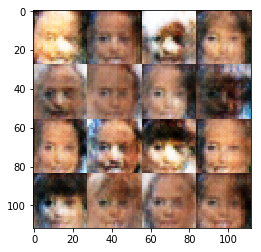

Epoch 1/2... Discriminator Loss: 1.3835... Generator Loss: 0.7869
Epoch 1/2... Discriminator Loss: 1.3847... Generator Loss: 0.7599
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7750
Epoch 1/2... Discriminator Loss: 1.3844... Generator Loss: 0.7609
Epoch 1/2... Discriminator Loss: 1.3805... Generator Loss: 0.7783
Epoch 1/2... Discriminator Loss: 1.3747... Generator Loss: 0.7691
Epoch 1/2... Discriminator Loss: 1.4485... Generator Loss: 0.8041
Epoch 1/2... Discriminator Loss: 1.3654... Generator Loss: 0.7986
Epoch 1/2... Discriminator Loss: 1.4192... Generator Loss: 0.7693
Epoch 1/2... Discriminator Loss: 1.3996... Generator Loss: 0.8235
Epoch 1/2... Discriminator Loss: 1.3819... Generator Loss: 0.8061
Epoch 1/2... Discriminator Loss: 1.4028... Generator Loss: 0.7994
Epoch 1/2... Discriminator Loss: 1.3965... Generator Loss: 0.7837
Epoch 1/2... Discriminator Loss: 1.4040... Generator Loss: 0.7893
Epoch 1/2... Discriminator Loss: 1.3941... Generator Loss: 0.8436
Epoch 1/2.

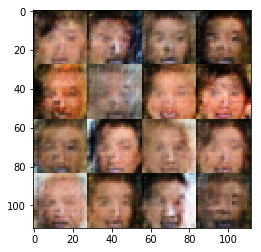

Epoch 1/2... Discriminator Loss: 1.3824... Generator Loss: 0.8220
Epoch 1/2... Discriminator Loss: 1.3919... Generator Loss: 0.8037
Epoch 1/2... Discriminator Loss: 1.3975... Generator Loss: 0.7811
Epoch 1/2... Discriminator Loss: 1.4128... Generator Loss: 0.7700
Epoch 1/2... Discriminator Loss: 1.4159... Generator Loss: 0.7625
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 0.8082
Epoch 1/2... Discriminator Loss: 1.3869... Generator Loss: 0.7656
Epoch 1/2... Discriminator Loss: 1.3816... Generator Loss: 0.7808
Epoch 1/2... Discriminator Loss: 1.3729... Generator Loss: 0.8141
Epoch 1/2... Discriminator Loss: 1.3997... Generator Loss: 0.8758
Epoch 1/2... Discriminator Loss: 1.3625... Generator Loss: 0.7799
Epoch 1/2... Discriminator Loss: 1.3817... Generator Loss: 0.8202
Epoch 1/2... Discriminator Loss: 1.4093... Generator Loss: 0.7416
Epoch 1/2... Discriminator Loss: 1.3808... Generator Loss: 0.8127
Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 0.8146
Epoch 1/2.

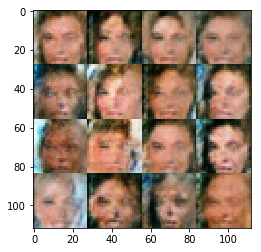

Epoch 1/2... Discriminator Loss: 1.3854... Generator Loss: 0.7645
Epoch 1/2... Discriminator Loss: 1.4183... Generator Loss: 0.8294
Epoch 1/2... Discriminator Loss: 1.3736... Generator Loss: 0.7928
Epoch 1/2... Discriminator Loss: 1.3747... Generator Loss: 0.8172
Epoch 1/2... Discriminator Loss: 1.3784... Generator Loss: 0.7628
Epoch 1/2... Discriminator Loss: 1.3906... Generator Loss: 0.8314
Epoch 1/2... Discriminator Loss: 1.4040... Generator Loss: 0.7697
Epoch 1/2... Discriminator Loss: 1.3819... Generator Loss: 0.7366
Epoch 1/2... Discriminator Loss: 1.4030... Generator Loss: 0.7820
Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 0.7604
Epoch 1/2... Discriminator Loss: 1.3611... Generator Loss: 0.8046
Epoch 1/2... Discriminator Loss: 1.3977... Generator Loss: 0.7653
Epoch 1/2... Discriminator Loss: 1.3963... Generator Loss: 0.8618
Epoch 1/2... Discriminator Loss: 1.3649... Generator Loss: 0.7194
Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 0.7853
Epoch 1/2.

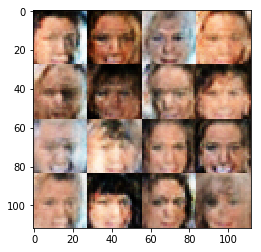

Epoch 1/2... Discriminator Loss: 1.3860... Generator Loss: 0.8215
Epoch 1/2... Discriminator Loss: 1.3984... Generator Loss: 0.7533
Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 0.7673
Epoch 1/2... Discriminator Loss: 1.3974... Generator Loss: 0.8052
Epoch 1/2... Discriminator Loss: 1.3790... Generator Loss: 0.7688
Epoch 1/2... Discriminator Loss: 1.3747... Generator Loss: 0.7537
Epoch 1/2... Discriminator Loss: 1.3991... Generator Loss: 0.7514
Epoch 1/2... Discriminator Loss: 1.4111... Generator Loss: 0.7726
Epoch 1/2... Discriminator Loss: 1.3679... Generator Loss: 0.8084
Epoch 1/2... Discriminator Loss: 1.4050... Generator Loss: 0.7968
Epoch 1/2... Discriminator Loss: 1.4017... Generator Loss: 0.7754
Epoch 1/2... Discriminator Loss: 1.3949... Generator Loss: 0.7513
Epoch 1/2... Discriminator Loss: 1.3872... Generator Loss: 0.7933
Epoch 1/2... Discriminator Loss: 1.4111... Generator Loss: 0.7971
Epoch 1/2... Discriminator Loss: 1.4300... Generator Loss: 0.7824
Epoch 1/2.

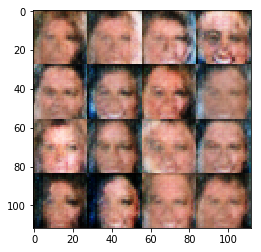

Epoch 1/2... Discriminator Loss: 1.3654... Generator Loss: 0.8285
Epoch 1/2... Discriminator Loss: 1.4037... Generator Loss: 0.7863
Epoch 1/2... Discriminator Loss: 1.3610... Generator Loss: 0.7731
Epoch 1/2... Discriminator Loss: 1.3941... Generator Loss: 0.8724
Epoch 1/2... Discriminator Loss: 1.3820... Generator Loss: 0.8049
Epoch 1/2... Discriminator Loss: 1.4100... Generator Loss: 0.7596
Epoch 1/2... Discriminator Loss: 1.4071... Generator Loss: 0.7278
Epoch 1/2... Discriminator Loss: 1.3915... Generator Loss: 0.8422
Epoch 1/2... Discriminator Loss: 1.4098... Generator Loss: 0.7864
Epoch 1/2... Discriminator Loss: 1.4094... Generator Loss: 0.7897
Epoch 1/2... Discriminator Loss: 1.3933... Generator Loss: 0.8116
Epoch 1/2... Discriminator Loss: 1.3640... Generator Loss: 0.7959
Epoch 1/2... Discriminator Loss: 1.3844... Generator Loss: 0.7934
Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 0.7750
Epoch 1/2... Discriminator Loss: 1.4050... Generator Loss: 0.7887
Epoch 1/2.

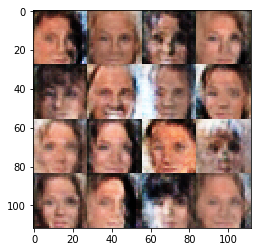

Epoch 1/2... Discriminator Loss: 1.3871... Generator Loss: 0.8441
Epoch 1/2... Discriminator Loss: 1.3688... Generator Loss: 0.8273
Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 0.7932
Epoch 1/2... Discriminator Loss: 1.3839... Generator Loss: 0.8255
Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 0.8283
Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.8303
Epoch 1/2... Discriminator Loss: 1.3771... Generator Loss: 0.7709
Epoch 1/2... Discriminator Loss: 1.3805... Generator Loss: 0.8137
Epoch 1/2... Discriminator Loss: 1.4081... Generator Loss: 0.7680
Epoch 1/2... Discriminator Loss: 1.4131... Generator Loss: 0.8527
Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 0.7936
Epoch 1/2... Discriminator Loss: 1.3992... Generator Loss: 0.7920
Epoch 1/2... Discriminator Loss: 1.3794... Generator Loss: 0.8288
Epoch 1/2... Discriminator Loss: 1.3938... Generator Loss: 0.8045
Epoch 1/2... Discriminator Loss: 1.3736... Generator Loss: 0.7899
Epoch 1/2.

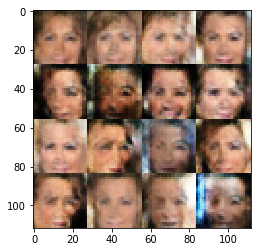

Epoch 1/2... Discriminator Loss: 1.3506... Generator Loss: 0.8242
Epoch 1/2... Discriminator Loss: 1.4087... Generator Loss: 0.7066
Epoch 1/2... Discriminator Loss: 1.4192... Generator Loss: 0.7893
Epoch 1/2... Discriminator Loss: 1.3872... Generator Loss: 0.8194
Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 0.7888
Epoch 1/2... Discriminator Loss: 1.3592... Generator Loss: 0.8224
Epoch 1/2... Discriminator Loss: 1.3816... Generator Loss: 0.7174
Epoch 1/2... Discriminator Loss: 1.3844... Generator Loss: 0.7911
Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 0.7696
Epoch 1/2... Discriminator Loss: 1.4114... Generator Loss: 0.7903
Epoch 1/2... Discriminator Loss: 1.3740... Generator Loss: 0.7466
Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 0.7654
Epoch 1/2... Discriminator Loss: 1.4176... Generator Loss: 0.7589
Epoch 1/2... Discriminator Loss: 1.3925... Generator Loss: 0.7862
Epoch 1/2... Discriminator Loss: 1.4160... Generator Loss: 0.7978
Epoch 1/2.

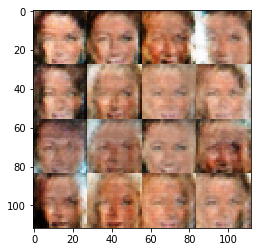

Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 0.8485
Epoch 1/2... Discriminator Loss: 1.3880... Generator Loss: 0.7790
Epoch 1/2... Discriminator Loss: 1.3650... Generator Loss: 0.7497
Epoch 1/2... Discriminator Loss: 1.3756... Generator Loss: 0.7723
Epoch 1/2... Discriminator Loss: 1.4080... Generator Loss: 0.7617
Epoch 1/2... Discriminator Loss: 1.4094... Generator Loss: 0.7977
Epoch 1/2... Discriminator Loss: 1.3755... Generator Loss: 0.7816
Epoch 1/2... Discriminator Loss: 1.3881... Generator Loss: 0.8091
Epoch 1/2... Discriminator Loss: 1.4065... Generator Loss: 0.8229
Epoch 1/2... Discriminator Loss: 1.3747... Generator Loss: 0.7623
Epoch 1/2... Discriminator Loss: 1.4119... Generator Loss: 0.8160
Epoch 1/2... Discriminator Loss: 1.3955... Generator Loss: 0.7942
Epoch 1/2... Discriminator Loss: 1.3961... Generator Loss: 0.7913
Epoch 1/2... Discriminator Loss: 1.3976... Generator Loss: 0.8710
Epoch 1/2... Discriminator Loss: 1.3541... Generator Loss: 0.7612
Epoch 1/2.

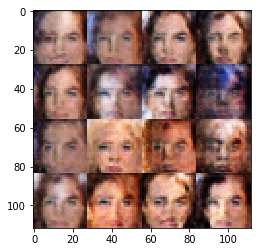

Epoch 1/2... Discriminator Loss: 1.3976... Generator Loss: 0.7844
Epoch 1/2... Discriminator Loss: 1.3784... Generator Loss: 0.7852
Epoch 1/2... Discriminator Loss: 1.3938... Generator Loss: 0.8531
Epoch 1/2... Discriminator Loss: 1.3847... Generator Loss: 0.7822
Epoch 1/2... Discriminator Loss: 1.4033... Generator Loss: 0.7804
Epoch 1/2... Discriminator Loss: 1.3943... Generator Loss: 0.8048
Epoch 1/2... Discriminator Loss: 1.3603... Generator Loss: 0.7683
Epoch 1/2... Discriminator Loss: 1.3994... Generator Loss: 0.7649
Epoch 1/2... Discriminator Loss: 1.3738... Generator Loss: 0.7648
Epoch 1/2... Discriminator Loss: 1.4040... Generator Loss: 0.8374
Epoch 1/2... Discriminator Loss: 1.3917... Generator Loss: 0.7459
Epoch 1/2... Discriminator Loss: 1.3745... Generator Loss: 0.7982
Epoch 1/2... Discriminator Loss: 1.4007... Generator Loss: 0.8108
Epoch 1/2... Discriminator Loss: 1.3805... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 1.3945... Generator Loss: 0.8397
Epoch 1/2.

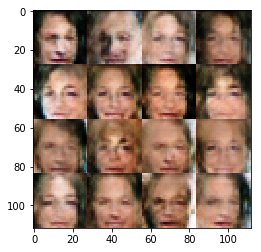

Epoch 1/2... Discriminator Loss: 1.3958... Generator Loss: 0.8304
Epoch 1/2... Discriminator Loss: 1.3973... Generator Loss: 0.8012
Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 0.7751
Epoch 1/2... Discriminator Loss: 1.4078... Generator Loss: 0.8150
Epoch 1/2... Discriminator Loss: 1.3822... Generator Loss: 0.7498
Epoch 1/2... Discriminator Loss: 1.3878... Generator Loss: 0.7948
Epoch 1/2... Discriminator Loss: 1.3680... Generator Loss: 0.8502
Epoch 1/2... Discriminator Loss: 1.3579... Generator Loss: 0.7559
Epoch 1/2... Discriminator Loss: 1.3977... Generator Loss: 0.8187
Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 0.7817
Epoch 1/2... Discriminator Loss: 1.3702... Generator Loss: 0.7347
Epoch 1/2... Discriminator Loss: 1.4206... Generator Loss: 0.8458
Epoch 1/2... Discriminator Loss: 1.3879... Generator Loss: 0.7762
Epoch 1/2... Discriminator Loss: 1.4021... Generator Loss: 0.7770
Epoch 1/2... Discriminator Loss: 1.3844... Generator Loss: 0.7894
Epoch 1/2.

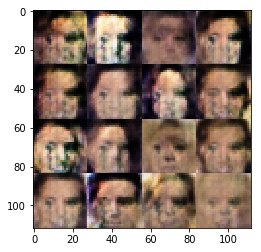

Epoch 1/2... Discriminator Loss: 1.3671... Generator Loss: 0.7885
Epoch 1/2... Discriminator Loss: 1.4111... Generator Loss: 0.7394
Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 0.7320
Epoch 1/2... Discriminator Loss: 1.3839... Generator Loss: 0.7907
Epoch 1/2... Discriminator Loss: 1.3850... Generator Loss: 0.8368
Epoch 1/2... Discriminator Loss: 1.3964... Generator Loss: 0.7820
Epoch 1/2... Discriminator Loss: 1.4005... Generator Loss: 0.8273
Epoch 1/2... Discriminator Loss: 1.3813... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 1.3767... Generator Loss: 0.8333
Epoch 1/2... Discriminator Loss: 1.3961... Generator Loss: 0.7862
Epoch 1/2... Discriminator Loss: 1.3983... Generator Loss: 0.7833
Epoch 1/2... Discriminator Loss: 1.3987... Generator Loss: 0.8375
Epoch 1/2... Discriminator Loss: 1.3676... Generator Loss: 0.7773
Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 0.8315
Epoch 1/2... Discriminator Loss: 1.4017... Generator Loss: 0.8229
Epoch 1/2.

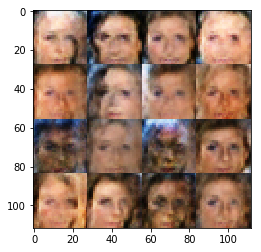

Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 0.7864
Epoch 1/2... Discriminator Loss: 1.3797... Generator Loss: 0.7782
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.7756
Epoch 1/2... Discriminator Loss: 1.3994... Generator Loss: 0.7567
Epoch 1/2... Discriminator Loss: 1.3950... Generator Loss: 0.7978
Epoch 1/2... Discriminator Loss: 1.4014... Generator Loss: 0.8150
Epoch 1/2... Discriminator Loss: 1.3816... Generator Loss: 0.8241
Epoch 1/2... Discriminator Loss: 1.3715... Generator Loss: 0.7767
Epoch 1/2... Discriminator Loss: 1.4000... Generator Loss: 0.7490
Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 0.7596
Epoch 1/2... Discriminator Loss: 1.3756... Generator Loss: 0.7938
Epoch 1/2... Discriminator Loss: 1.3658... Generator Loss: 0.7721
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.8323
Epoch 1/2... Discriminator Loss: 1.4229... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.7726
Epoch 1/2.

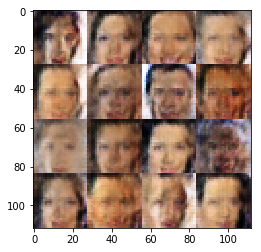

Epoch 1/2... Discriminator Loss: 1.3788... Generator Loss: 0.8043
Epoch 1/2... Discriminator Loss: 1.3671... Generator Loss: 0.8420
Epoch 1/2... Discriminator Loss: 1.3759... Generator Loss: 0.7604
Epoch 1/2... Discriminator Loss: 1.4014... Generator Loss: 0.7465
Epoch 1/2... Discriminator Loss: 1.4236... Generator Loss: 0.7758
Epoch 1/2... Discriminator Loss: 1.4041... Generator Loss: 0.7969
Epoch 1/2... Discriminator Loss: 1.3832... Generator Loss: 0.8160
Epoch 1/2... Discriminator Loss: 1.3780... Generator Loss: 0.8213
Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 0.7928
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.8460
Epoch 1/2... Discriminator Loss: 1.3806... Generator Loss: 0.8333
Epoch 1/2... Discriminator Loss: 1.3611... Generator Loss: 0.8143
Epoch 1/2... Discriminator Loss: 1.3625... Generator Loss: 0.7781
Epoch 1/2... Discriminator Loss: 1.4033... Generator Loss: 0.7443
Epoch 1/2... Discriminator Loss: 1.3816... Generator Loss: 0.7571
Epoch 1/2.

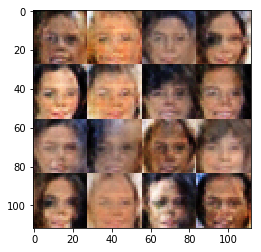

Epoch 1/2... Discriminator Loss: 1.3694... Generator Loss: 0.7721
Epoch 1/2... Discriminator Loss: 1.3684... Generator Loss: 0.7413
Epoch 1/2... Discriminator Loss: 1.3684... Generator Loss: 0.7961
Epoch 1/2... Discriminator Loss: 1.3800... Generator Loss: 0.7671
Epoch 1/2... Discriminator Loss: 1.4155... Generator Loss: 0.7588
Epoch 1/2... Discriminator Loss: 1.3598... Generator Loss: 0.7940
Epoch 1/2... Discriminator Loss: 1.3890... Generator Loss: 0.7591
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.8058
Epoch 1/2... Discriminator Loss: 1.3591... Generator Loss: 0.8251
Epoch 1/2... Discriminator Loss: 1.4102... Generator Loss: 0.7753
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.9053
Epoch 1/2... Discriminator Loss: 1.3926... Generator Loss: 0.7865
Epoch 1/2... Discriminator Loss: 1.3904... Generator Loss: 0.8246
Epoch 1/2... Discriminator Loss: 1.3660... Generator Loss: 0.7957
Epoch 1/2... Discriminator Loss: 1.3914... Generator Loss: 0.8047
Epoch 1/2.

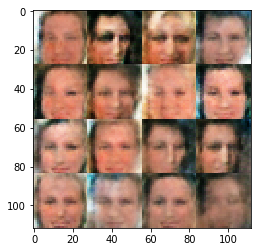

Epoch 1/2... Discriminator Loss: 1.3796... Generator Loss: 0.8087
Epoch 1/2... Discriminator Loss: 1.3685... Generator Loss: 0.7684
Epoch 1/2... Discriminator Loss: 1.3970... Generator Loss: 0.8210
Epoch 1/2... Discriminator Loss: 1.4057... Generator Loss: 0.7974
Epoch 1/2... Discriminator Loss: 1.3848... Generator Loss: 0.7722
Epoch 1/2... Discriminator Loss: 1.3938... Generator Loss: 0.7784
Epoch 1/2... Discriminator Loss: 1.3834... Generator Loss: 0.8302
Epoch 1/2... Discriminator Loss: 1.3896... Generator Loss: 0.7454
Epoch 1/2... Discriminator Loss: 1.3712... Generator Loss: 0.7872
Epoch 1/2... Discriminator Loss: 1.3736... Generator Loss: 0.7740
Epoch 1/2... Discriminator Loss: 1.3736... Generator Loss: 0.7448
Epoch 1/2... Discriminator Loss: 1.3809... Generator Loss: 0.8090
Epoch 1/2... Discriminator Loss: 1.3986... Generator Loss: 0.8094
Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 0.7518
Epoch 1/2... Discriminator Loss: 1.4015... Generator Loss: 0.7377
Epoch 1/2.

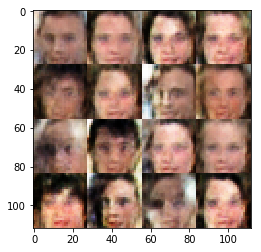

Epoch 1/2... Discriminator Loss: 1.4056... Generator Loss: 0.7927
Epoch 1/2... Discriminator Loss: 1.3914... Generator Loss: 0.7874
Epoch 1/2... Discriminator Loss: 1.3974... Generator Loss: 0.7927
Epoch 1/2... Discriminator Loss: 1.3792... Generator Loss: 0.7771
Epoch 1/2... Discriminator Loss: 1.3980... Generator Loss: 0.7692
Epoch 1/2... Discriminator Loss: 1.3735... Generator Loss: 0.8184
Epoch 1/2... Discriminator Loss: 1.3761... Generator Loss: 0.8116
Epoch 1/2... Discriminator Loss: 1.4055... Generator Loss: 0.7723
Epoch 1/2... Discriminator Loss: 1.3800... Generator Loss: 0.7979
Epoch 1/2... Discriminator Loss: 1.3767... Generator Loss: 0.8144
Epoch 1/2... Discriminator Loss: 1.3640... Generator Loss: 0.8046
Epoch 1/2... Discriminator Loss: 1.3880... Generator Loss: 0.8137
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.8022
Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.7945
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7734
Epoch 1/2.

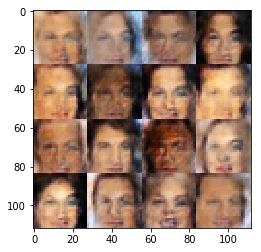

Epoch 1/2... Discriminator Loss: 1.4079... Generator Loss: 0.7966
Epoch 1/2... Discriminator Loss: 1.3953... Generator Loss: 0.7448
Epoch 1/2... Discriminator Loss: 1.4149... Generator Loss: 0.7865
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 0.8421
Epoch 1/2... Discriminator Loss: 1.3840... Generator Loss: 0.7871
Epoch 1/2... Discriminator Loss: 1.3869... Generator Loss: 0.7427
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.7903
Epoch 1/2... Discriminator Loss: 1.3706... Generator Loss: 0.8298
Epoch 1/2... Discriminator Loss: 1.3908... Generator Loss: 0.7932
Epoch 1/2... Discriminator Loss: 1.3600... Generator Loss: 0.8060
Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 0.8085
Epoch 1/2... Discriminator Loss: 1.3915... Generator Loss: 0.7826
Epoch 1/2... Discriminator Loss: 1.3945... Generator Loss: 0.7452
Epoch 1/2... Discriminator Loss: 1.3943... Generator Loss: 0.8375
Epoch 1/2... Discriminator Loss: 1.3977... Generator Loss: 0.7857
Epoch 1/2.

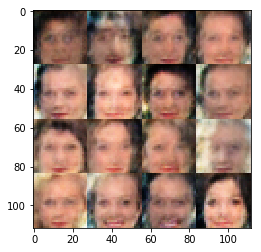

Epoch 1/2... Discriminator Loss: 1.3790... Generator Loss: 0.8277
Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 0.8242
Epoch 1/2... Discriminator Loss: 1.3953... Generator Loss: 0.7375
Epoch 1/2... Discriminator Loss: 1.3848... Generator Loss: 0.8042
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 0.7752
Epoch 1/2... Discriminator Loss: 1.3980... Generator Loss: 0.7779
Epoch 1/2... Discriminator Loss: 1.3733... Generator Loss: 0.7934
Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 0.7389
Epoch 1/2... Discriminator Loss: 1.3808... Generator Loss: 0.8144
Epoch 1/2... Discriminator Loss: 1.3918... Generator Loss: 0.7524
Epoch 1/2... Discriminator Loss: 1.4014... Generator Loss: 0.7659
Epoch 1/2... Discriminator Loss: 1.3694... Generator Loss: 0.7704
Epoch 1/2... Discriminator Loss: 1.3741... Generator Loss: 0.7732
Epoch 1/2... Discriminator Loss: 1.4098... Generator Loss: 0.7817
Epoch 1/2... Discriminator Loss: 1.4522... Generator Loss: 0.8060
Epoch 1/2.

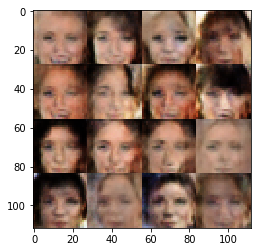

Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 0.7876
Epoch 1/2... Discriminator Loss: 1.3535... Generator Loss: 0.7990
Epoch 1/2... Discriminator Loss: 1.3775... Generator Loss: 0.7361
Epoch 1/2... Discriminator Loss: 1.3727... Generator Loss: 0.7949
Epoch 1/2... Discriminator Loss: 1.4101... Generator Loss: 0.7741
Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 0.7670
Epoch 1/2... Discriminator Loss: 1.4036... Generator Loss: 0.7670
Epoch 1/2... Discriminator Loss: 1.4091... Generator Loss: 0.8146
Epoch 1/2... Discriminator Loss: 1.3914... Generator Loss: 0.8238
Epoch 1/2... Discriminator Loss: 1.3794... Generator Loss: 0.7634
Epoch 1/2... Discriminator Loss: 1.3805... Generator Loss: 0.7612
Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 0.7868
Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 0.8024
Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 0.7945
Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 0.8293
Epoch 1/2.

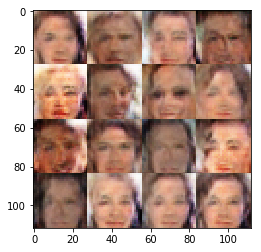

Epoch 1/2... Discriminator Loss: 1.3846... Generator Loss: 0.7993
Epoch 1/2... Discriminator Loss: 1.3925... Generator Loss: 0.8137
Epoch 1/2... Discriminator Loss: 1.4089... Generator Loss: 0.7417
Epoch 1/2... Discriminator Loss: 1.3755... Generator Loss: 0.7731
Epoch 1/2... Discriminator Loss: 1.4103... Generator Loss: 0.7775
Epoch 1/2... Discriminator Loss: 1.3741... Generator Loss: 0.8495
Epoch 1/2... Discriminator Loss: 1.3649... Generator Loss: 0.8134
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 0.8299
Epoch 1/2... Discriminator Loss: 1.4114... Generator Loss: 0.7707
Epoch 1/2... Discriminator Loss: 1.4134... Generator Loss: 0.7753
Epoch 1/2... Discriminator Loss: 1.3904... Generator Loss: 0.8281
Epoch 1/2... Discriminator Loss: 1.3851... Generator Loss: 0.7587
Epoch 1/2... Discriminator Loss: 1.3785... Generator Loss: 0.8146
Epoch 1/2... Discriminator Loss: 1.3678... Generator Loss: 0.8689
Epoch 1/2... Discriminator Loss: 1.4001... Generator Loss: 0.7960
Epoch 1/2.

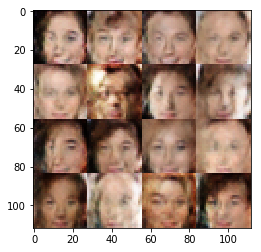

Epoch 1/2... Discriminator Loss: 1.3943... Generator Loss: 0.7944
Epoch 1/2... Discriminator Loss: 1.4272... Generator Loss: 0.7652
Epoch 1/2... Discriminator Loss: 1.4009... Generator Loss: 0.7661
Epoch 1/2... Discriminator Loss: 1.3917... Generator Loss: 0.7753
Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 0.7984
Epoch 1/2... Discriminator Loss: 1.3968... Generator Loss: 0.7478
Epoch 1/2... Discriminator Loss: 1.3606... Generator Loss: 0.7907
Epoch 1/2... Discriminator Loss: 1.4130... Generator Loss: 0.8189
Epoch 1/2... Discriminator Loss: 1.3914... Generator Loss: 0.7905
Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 0.7839
Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 0.8387
Epoch 1/2... Discriminator Loss: 1.4119... Generator Loss: 0.7738
Epoch 1/2... Discriminator Loss: 1.3924... Generator Loss: 0.7850
Epoch 1/2... Discriminator Loss: 1.3687... Generator Loss: 0.7826
Epoch 1/2... Discriminator Loss: 1.3820... Generator Loss: 0.7706
Epoch 1/2.

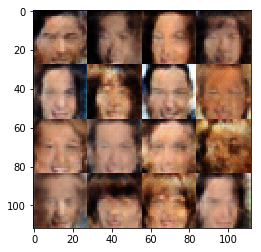

Epoch 1/2... Discriminator Loss: 1.3606... Generator Loss: 0.8516
Epoch 1/2... Discriminator Loss: 1.3600... Generator Loss: 0.7823
Epoch 1/2... Discriminator Loss: 1.3837... Generator Loss: 0.8199
Epoch 1/2... Discriminator Loss: 1.4134... Generator Loss: 0.7421
Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 0.7456
Epoch 1/2... Discriminator Loss: 1.4109... Generator Loss: 0.7694


In [42]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.